# Preparation of PLL filters use python-control version *0.9.4*

## Application
Prepared during TTR-110.0008
In use for TTR-111.0009

In [1]:
from astropy.io import fits
import numpy as np
from scipy import signal as sig
from matplotlib import pyplot as plt
import os,subprocess,glob
import control
import sympy as sp

import pytac
from pytac import tac_obj
from pytac import params2source

from IPython.display import display

def tf_upgrade(atf):
    newtf = control.tf(atf.num, atf.den, atf.dt)
    return newtf
import pickle
with open("data/fitted_DL_TF.p", "rb") as afile:
    DL_TF = tf_upgrade(pickle.load(afile))

# Some utilities

In [2]:
#import sympy as sp
#s, z = sp.symbols("s, z")
def control2sp(atf, asymbol):
    alist = [a * asymbol**i  for i, a in enumerate(np.flip(atf.num[0][0]))]
    num = sp.Add(*alist)
    alist = [a * asymbol**i  for i, a in enumerate(np.flip(atf.den[0][0]))]
    den = sp.Add(*alist)
    return num/den
def sp2control(atf, T_symbol, dt=1):
    
    num, den = atf.subs([(T_symbol, dt)]).as_numer_denom()
    if num.as_poly() is not None:
        numfloat = np.array(num.as_poly().all_coeffs(), dtype=np.float64)
    else:
        numfloat = 1
    if den.as_poly() is not None:
        denfloat = np.array(den.as_poly().all_coeffs(), dtype=np.float64)
    else:
        denfloat = 1
    H = control.tf(numfloat, denfloat , dt=dt)
    return H


for a in 

In [3]:
from pdb import set_trace
def resample_tf(atf, order, Ts_final, Ts_original=None, full_output=True, verbose=False):
    intermediate = {}
    s, z = sp.symbols("s, z")
    T = sp.symbols("T", real=True)
    if Ts_original is None:
        Ts_original = atf.dt
    print(f"Starting from T = {Ts_original}")
    
    #z_continuous = (1+s*T/2) / (1-s*T/2)
    re_order = order+1
    intermediate["order"] = order
    z_continuous = sp.series(sp.exp(s*T/2), x=s, n=re_order).removeO()/sp.series(sp.exp(-s*T/2), x=s, n=re_order).removeO()
    intermediate["z_continuous"] = z_continuous
    sympy_sys = control2sp(atf, z)
    intermediate["sympy_sys"] = sympy_sys
    continuous_system = sympy_sys.subs([(z, z_continuous), (T, Ts_original)])
    intermediate["continuous_system"] = continuous_system
    rational_sys = sp.simplify(continuous_system)
    intermediate["rational_sys"] = rational_sys
    num = rational_sys.separate().args[1]
    num_coeffs = np.array(num.as_poly().all_coeffs()).astype(np.float64)
    den = rational_sys.separate().args[0].args[0]
    den_coeffs = np.array(den.as_poly().all_coeffs()).astype(np.float64)
    continuous_system_tf = control.tf(num_coeffs, den_coeffs)
    intermediate["continuous_system_tf"] = continuous_system_tf
    #set_trace()
    print(f"Resampling at T = {Ts_final}")
    resampled_sys = continuous_system_tf.sample(Ts=Ts_final)
    
    if full_output:
        return resampled_sys, intermediate
    else:
        return resampled_sys

In [4]:
ts = 0.25e-3

In [5]:
z_control = control.TransferFunction.z
z_control.dt = ts
derivator_simple = 1/ts*( 1 - z_control**(-1))
integrator_simple = ts*1/(1-z_control**(-1))
s, z = sp.symbols("s, z")
T = sp.symbols("T", real=True)
re_order = 2
z_continuous = sp.series(sp.exp(s*T/2), x=s, n=re_order).removeO()/sp.series(sp.exp(-s*T/2), x=s, n=re_order).removeO()
s_approx_1 = sp.solve(z_continuous-z, s)[0]

# Digital Filter



## From the manual
Directly copied from VLT-MAN-ESO-15400-4234 : VLTI - UT Vibration Monitoring System, Software User and Maintenance Manual

In [6]:

gain1 = 0.967139753776691
num1 = np.array([-0.990977393368562, 1])[::-1]
den1 = np.array([-0.993221504038126, 1])[::-1]
tf1 = control.tf(num1*gain1, den1, 0.00025)

gain2 = 1.55943205022896e-008
num2 = np.array([1.0, 2.0, 1])[::-1]
den2 = np.array([0.996080719781782, -1.99606532880436, 1])[::-1]
tf2 = control.tf(num2*gain2, den2, 0.00025)

gain3 = 4.16571583930859
num3 = np.array([0.789213276774273, -1.78921327677427, 1])[::-1]
den3 = np.array([0.119727214363492, -1.11627901172445, 1])[::-1]
tf3 = control.tf(num3*gain3, den3, 0.00025)

tf_from_manual = control.series(tf1, tf2, tf3)

original_tf_numden = np.array([[gain1, num1[0], num1[1], den1[0], den1[1]],
                           [gain2, num2[0], num2[1], den2[0], den2[1]],
                           [gain3, num3[0], num3[1], den3[0], den3[1]]])
original_tf_TAC = np.array([[gain1, num1[1], 0, den1[1], 0],
                           [gain2, num2[1], num2[2], den2[1], den2[2]],
                           [gain3, num3[1], num3[2], den3[1], den3[2]]])

In [7]:
def get_order(atf):
    numorder = atf.num[0][0].shape[0]-1
    denorder = atf.den[0][0].shape[0]-1
    return(np.max(numorder, denorder))
def get_degree_sp(expr):
    if expr == 1:
        return 0
    else:
        return sp.Poly(sp.expand(expr)).degree()

def get_stable_approx_inverse(atf, verbose=False, z=z,
                             regularize=True):
    """
    Produces an approximate inverse following the method in Maggio2020
    
    *Parameters:*
    * atf   : transfer function of the actuator.
    * verbose: if `True`, will plot some information
    * z     : The sympy symbol to use for manipulating the transfer function
      internally
    * regulariz: If `True`, will add a delay to try to make the function causal
    
    """
    B = control.tf(atf.num, 1, z_control.dt)
    A = control.tf(atf.den, 1, z_control.dt)
    plt.figure()
    poles, zeros = control.pzmap(atf, grid=True)
    if not verbose:
        plt.close()
    else :
        plt.show()
        print(f"zeros : {np.abs(zeros)}")
    isoutside = np.abs(zeros)> 1
    outsidezeros = zeros[isoutside]
    insidezeros = zeros[np.logical_not(isoutside)]
    if verbose:
        print(zeros)
    Asp = control2sp(A, z)
    Bsp = control2sp(B, z)
    Bpoly = sp.Poly(Bsp)
    Bgain = Bpoly.all_coeffs()[0]
    Again = sp.Poly(Asp).all_coeffs()[0]
    #Bgain = sp.factor(Bsp).args[0]
    #Again = sp.factor(Asp).args[0]
    Bplus = sp.Mul(*[(z-azero) for azero in insidezeros])
    Bminus = Bgain*sp.Mul(*[(z-azero) for azero in outsidezeros])
    degA = sp.Poly(Asp).degree()
    degB = sp.Poly(Bsp).degree()
    if regularize:
        d_condition = 1*((degA - degB)>=1 )
    else:
        d_condition = 0
    degBminus = sp.Poly(sp.expand(Bminus)).degree()
    degBplus = get_degree_sp(Bplus)
    #Asp/(z**d*)
    #print("poles:",B.zeros())

    Bstarminus = sp.expand(z**degBminus * Bminus.subs([(z, 1/z)]))

    Bstarminus_tf = sp2control(Bstarminus, T_symbol=z_control, dt=z_control.dt)
    Bminus_tf = sp2control(Bminus, T_symbol=z_control, dt=z_control.dt)
    if verbose:
        plt.figure()
        control.pzmap(Bminus_tf, grid=True)
        plt.show()
        plt.figure()
        control.pzmap(Bstarminus_tf, grid=True)
        plt.show()

    Hdagger_sp = Asp/sp.expand(z**d_condition * Bplus * Bstarminus)
    Hdagger = sp2control(Hdagger_sp, z_control, dt=z_control.dt)
    #control.pzmap(Hdagger, grid=True)
    if verbose:
        plt.figure()
        dump, dump, omega_real = control.bode(
            1/Hdagger,
                    wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
                    label=f"$1/H^{{\dagger}}$")
        dump, dump, omega_real = control.bode(
            atf,
                    wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
                    label=f"$H_{{approx}}$")
        plt.legend()
    return Hdagger

In [8]:
pi = np.pi
ts = 1/4000;     # sampling time    
w0 = 4.33*2*pi;  # pole
w1 = 5.77*2*pi;  # zero
w3 = 2.5*2*pi;   # highpass
w4 = 1000*2*pi;  # pole
w5 = 150*2*pi;   # zero

In [9]:
g_1 = (w1*ts/2+1)/(w0*ts/2+1)*10**(-0.3/20);
a1_1 = (w1*ts/2-1)/(w1*ts/2+1);
b1_1 = (w0*ts/2-1)/(w0*ts/2+1);
tf_1 = control.tf(g_1*np.array([1, a1_1]),[1, b1_1],ts);

In [10]:
g_2 = ts**2/4/(1+w3*ts/2+(w3*ts/2)**2);
a1_2 = 2;
a2_2 = 1;
b1_2 = 2*((w3*ts/2)**2-1)/(1+w3*ts/2+(w3*ts/2)**2);
b2_2 = (1-w3*ts/2+(w3*ts/2)**2)/(1+w3*ts/2+(w3*ts/2)**2);
tf_2 = control.tf(g_2*np.array([1, a1_2, a2_2]),[1, b1_2, b2_2],ts);

In [11]:
g_3 = 1/(1+w3*ts/2);
a1_3 = -1;
b1_3 = (w3*ts/2-1)/(w3*ts/2+1);
tf_3 = control.tf(g_3*np.array([1, a1_3]),[1, b1_3],ts);

In [12]:
a1_4 = (w5*ts/2-1)/(w5*ts/2+1);
b1_4 = (w4*ts/2-1)/(w4*ts/2+1);
g_4 = (1+b1_4)/(1+a1_4);
tf_4 = control.tf(g_4*np.array([1, a1_4]),[1, b1_4],ts);

In [13]:
tf_rebuilt = tf_1*tf_2*tf_3*tf_4

In [14]:
import pickle
with open("data/tf_manhattan.p", "wb") as afile:
    pickle.dump(tf_rebuilt, afile)
#tfs = [tf_1, tf_2, tf_3, tf_4]
#print(np.array([np.concatenate((tf_x.num[0][0], tf_x.den[0][0])) for tf_x in tfs]))
# with open("data/tf_123.p", "wb") as afile:
#     pickle.dump(tf_1*tf_2*tf_3, afile)

In [15]:
hp_pll_int = tf_1*tf_2*tf_3

## From the source

In [16]:
## %% Digital TF filters in Manhattan LCU
## TAC_BLOCK TF1_M3 DigitalTF 0.967139753776691 -0.990977393368562 -0.993221504038126
## TAC_BLOCK TF2_M3 DigitalTF 1.55943205022896e-008 2 1 -1.99606532880436 0.996080719781782
## TAC_BLOCK TF3_M3 DigitalTF 4.16571583930859 -1.78921327677427 0.789213276774273 -1.11627901172445 0.119727214363492
#
#gain1 = 0.967139753776691
#num1 = np.array([-0.990977393368562, 1])[::-1]
#den1 = np.array([-0.993221504038126, 1])[::-1]
#tf1 = control.tf(num1*gain1, den1, 0.00025)
#
#gain2 = 1.55943205022896e-008
#num2 = np.array([1.0, 2.0, 1])[::-1]
#den2 = np.array([0.996080719781782, -1.99606532880436, 1])[::-1]
#tf2 = control.tf(num2*gain2, den2, 0.00025)
#
#gain3 = 4.16571583930859
#num3 = np.array([0.789213276774273, -1.78921327677427, 1])[::-1]
#den3 = np.array([0.119727214363492, -1.11627901172445, 1])[::-1]
#tf3 = control.tf(num3*gain3, den3, 0.00025)
#
#tf = control.series(tf1, tf2, tf3)


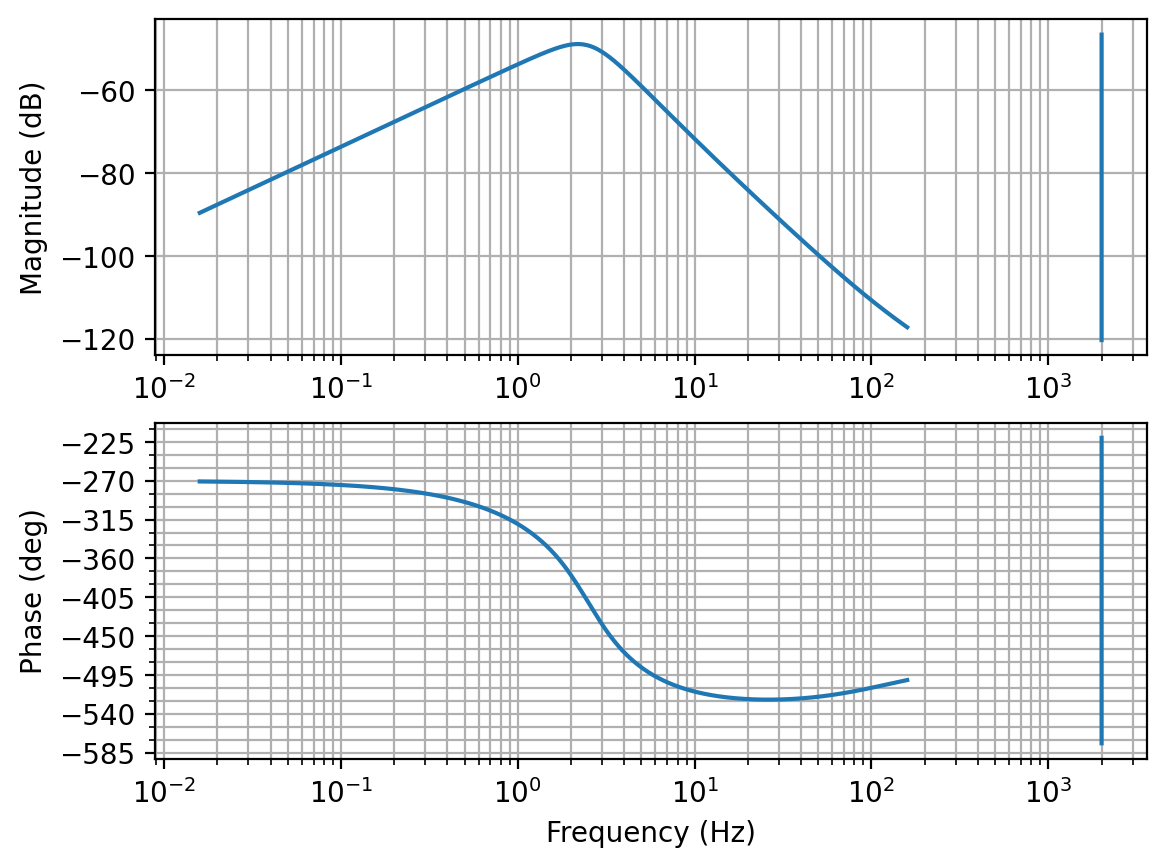

In [17]:
plt.figure(dpi=200)
mag, phase, omega = control.bode_plot(tf_rebuilt, Hz=True, dB=True,
                                      omega_limits=(0.1, 1000), plot=True, )
plt.show()

# The Delay Line models

## The main DL model

In [18]:
ts_mainDL = 500e-6
num_standard = (np.array([0.05484, 0.1861, 0.205, 0.09072, 0.01691]))
den_standard = (np.array([1., 0.4952, -0.9031, -0.3371, 0.2985, 0., 0.]))
standard_dl = control.tf(num_standard, den_standard, ts_mainDL)

num_modified = (np.array([0.1374, 0.4352, 0.4849, 0.2381, 0.0577]))
den_modified = (np.array([1., 0.9736, -0.2849, -0.3992, 0.06241, 0., 0.]))
modified_dl = control.tf(num_modified, den_modified, ts_mainDL)

# plt.figure(dpi=100)
# mag, phase, omega = control.bode_plot(standard_dl, Hz=True, dB=True,
#                                       omega_limits=(10., 3000), plot=True,
#                                      wrap_phase=True, label="With wrong capacitor")
# mag_mod, phase_mod, omega_mod = control.bode_plot(modified_dl, Hz=True, dB=True,
#                                       omega_limits=(10., 3000), plot=True,
#                                      wrap_phase=True, label="With new capacitor")
# plt.legend(loc="lower left", fontsize="x-small")
# plt.suptitle("Faulty vs repaired delay line")
# plt.show()



## The PRIMA DL model

In [19]:
s = control.TransferFunction.s
Q_bcddl_design = 1.69
omegac_bcddl_design = 2*np.pi*422.7
T_bcddl_design = 705.7e-6
num_bcddl_design = np.array([1.])
bcddl_delay_design = control.tf(*control.delay.pade(T_bcddl_design,n=4))
den_bcddl_design = np.array([1/omegac_bcddl_design**2, 1/(Q_bcddl_design*omegac_bcddl_design), 1.])
bcddl_design = bcddl_delay_design * control.tf(num_bcddl_design, den_bcddl_design)
bcddl_design_discrete = bcddl_design.sample(ts_mainDL)
bcddl_design_discrete_4kHz = bcddl_design.sample(ts)



In [20]:
s = control.TransferFunction.s
Q_prima_design = 1/np.sqrt(2)
omegac_prima_design = 2*np.pi*200
T_prima_design = 100.0e-6
num_prima_design = np.array([1.])
prima_delay_design = control.tf(*control.delay.pade(T_prima_design,n=4))
den_prima_design = np.array([1/omegac_prima_design**2, 1/(Q_prima_design*omegac_prima_design), 1.])
prima_design = prima_delay_design * control.tf(num_prima_design, den_prima_design)
prima_design_discrete = prima_design.sample(ts_mainDL)
prima_design_discrete_4kHz = prima_design.sample(ts)

In [21]:
s = control.TransferFunction.s
Q_prima_design = 0.6

omegac_prima_design = 2*np.pi*220
#T_prima_design = 650.0e-6
T_prima_design = 650.0e-6
#T_prima_design = 0
num_prima_design = np.array([1.])
prima_delay_design = control.tf(*control.delay.pade(T_prima_design,n=4))
den_prima_design = np.array([1/omegac_prima_design**2, 1/(Q_prima_design*omegac_prima_design), 1.])
prima_design = prima_delay_design * control.tf(num_prima_design, den_prima_design)
prima_design_discrete = prima_design.sample(ts_mainDL)
prima_design_discrete_4kHz = prima_design.sample(ts)

base_prima_design = control.tf(num_prima_design,
                               den_prima_design)
base_prima_discrete = base_prima_design.sample(ts,
                                method="zoh")
base_prima_discrete

TransferFunction(array([0.04925155, 0.04063631]), array([ 1.        , -1.47227782,  0.56216569]), 0.00025)

## Model from the Master thesis

In [22]:
def fit_multi_check(freqs, cgain, orders, mask, verbose=True):
    tfs = []
    fitmags = []
    fitphases = []
    fitomegas = []
    for i in orders:
        atf = pytac.get_levy(cgain[mask], freqs[mask], i)
        # atf = pytac.get_weighted_levy(tf1, freqj, i, sig=1/Cxy1**4)
        # atf = pytac.get_levy(tf1[:skiplast], freqj[:skiplast], i)
        mags, phases, omegas = control.bode_plot(atf, Hz=True, label=i, wrap_phase=True, alpha=0.5)
        fitmags.append(mags)
        fitphases.append(phases)
        fitomegas.append(omegas)
        tfs.append(atf)
        display(atf)
        #tf3 = pytac.get_levy(tf1, freqj, 4)
    plt.legend()
    fitmags = np.array(fitmags)
    fitphases = np.array(fitphases)
    fitomegas = np.array(fitomegas)
    
    if verbose:
        plt.figure(dpi=200)
        ax1 = plt.subplot(211)
        plt.title("Fitting of the feedforward piezo")
        plt.plot(freqs, np.abs(cgain), color="k", linestyle="--", linewidth=1, label="Measured")
        for i, (anom, amag, aphase) in enumerate(zip(fitomegas, fitmags, fitphases)):
            plt.plot(anom/(2*np.pi), amag, alpha=0.5, color=f"C{i}", label=f"{orders[i]}")
        plt.xlim(0.1, 2*np.max(freqs[mask]))
        plt.yscale("log")
        plt.xscale("log")
        ax2 = plt.subplot(212, sharex=ax1)
        plt.plot(freqs, np.angle(cgain), color="k", linestyle="--", linewidth=1,  label="Measured")
        for i, (anom, amag, aphase) in enumerate(zip(fitomegas, fitmags, fitphases)):
            plt.plot(anom/(2*np.pi), aphase, alpha=0.5, color=f"C{i}", label=f"{orders[i]}")
        plt.legend(fontsize=6)
        plt.show()
    
    return tfs

TransferFunction(array([ 1.062e+03,  4.476e+07,  2.146e+12,  5.903e+16,  1.387e+21,
        2.389e+25,  3.268e+29,  3.088e+33,  2.083e+37,  1.413e+41,
        3.641e+44,  1.935e+48, -5.794e+48]), array([1.000e+00, 2.952e+04, 1.833e+09, 3.979e+13, 1.136e+18, 1.709e+22,
       2.733e+26, 2.533e+30, 2.078e+34, 1.146e+38, 5.173e+41, 1.236e+45,
       1.898e+48, 2.450e+46]))

/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/control/xferfcn.py:1083: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/control/xferfcn.py:1113: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


TransferFunction(array([ 2.18060104e-08-1.50577769e-08j, -7.30360249e-05+7.11436010e-05j,
        1.01786732e+00+3.15109960e-02j]), array([9.61462435e-08+4.10697378e-08j, 4.44755026e-04+8.87354157e-05j,
       1.00000000e+00+0.00000000e+00j]))

TransferFunction(array([-3.27999188e-11-2.12504232e-11j,  2.00040434e-07+5.06498761e-07j,
        1.86618322e-03-1.39020881e-03j,  1.01237093e+00+5.00718473e-02j]), array([9.68649018e-11+4.57454162e-11j, 1.14731295e-06+1.18293243e-07j,
       2.46447999e-03-1.33767771e-03j, 1.00000000e+00+0.00000000e+00j]))

TransferFunction(array([ 9.18422765e-15-4.88321859e-14j, -1.19706078e-09+7.06418320e-10j,
       -1.31062966e-06+2.88008730e-06j, -1.31878671e-02+2.60591992e-02j,
        1.05717954e+00-2.43055215e-02j]), array([-5.52951148e-13+1.62017221e-13j, -3.77898706e-09+4.81197078e-09j,
       -7.19299116e-06+1.52127788e-05j, -1.22017814e-02+2.55864692e-02j,
        1.00000000e+00+0.00000000e+00j]))

TransferFunction(array([-2.44255599e-16+3.47886062e-17j, -2.04389069e-12+5.41926231e-12j,
       -5.36427227e-09+2.12649148e-08j, -9.59756356e-05+4.04482962e-04j,
        1.34468896e+00+7.77156250e-01j, -3.02144034e+00-2.28221836e+00j]), array([-3.64687112e-15+7.91504624e-16j, -2.18323132e-11+5.32120135e-11j,
        9.69322016e-08+2.90073251e-07j,  5.16086422e-04+7.51249869e-04j,
        1.31884474e+00+7.63089575e-01j,  1.00000000e+00+0.00000000e+00j]))

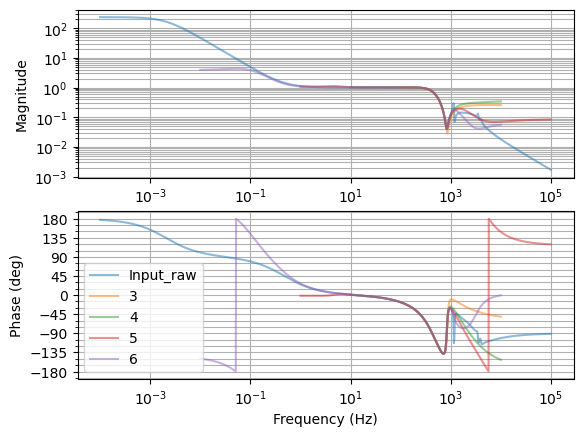

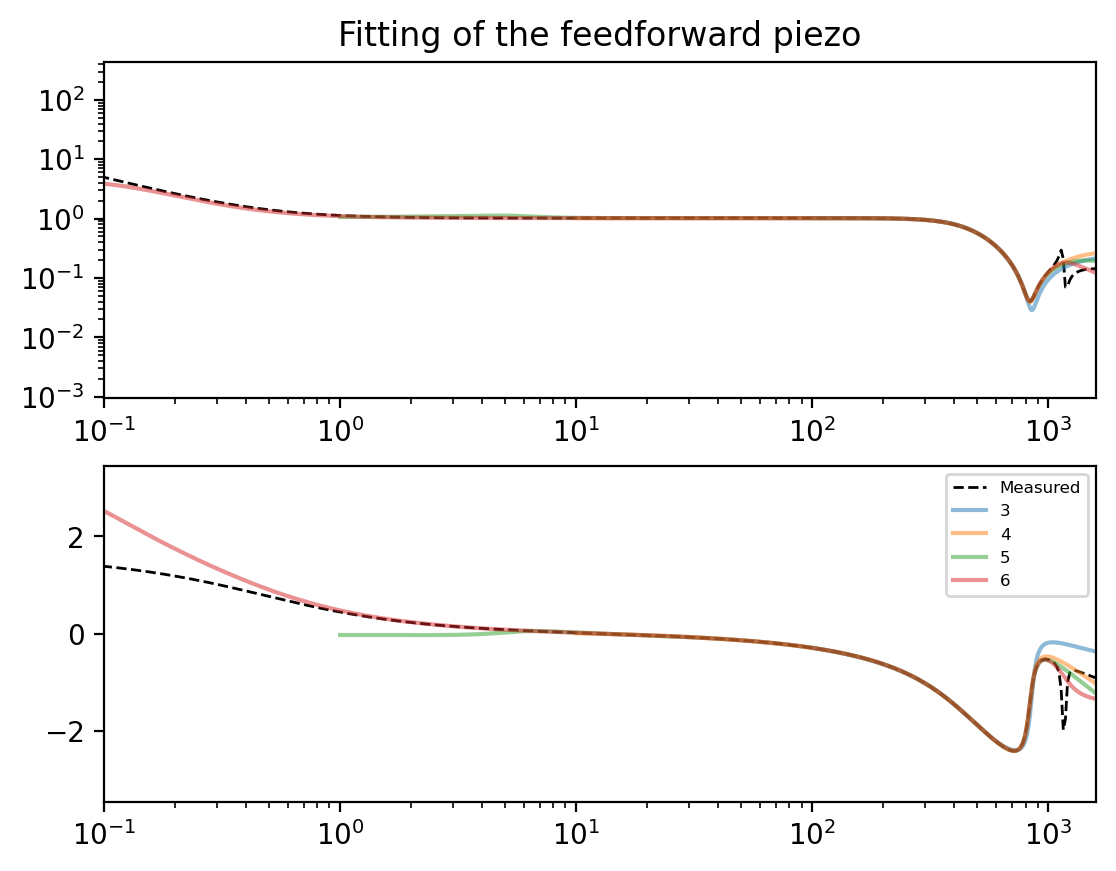

Order 5


/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:461: LinAlgWarning: Ill-conditioned matrix (rcond=5.77565e-17): result may not be accurate.
  ad = linalg.solve(ima, np.eye(a.shape[0]) + (1.0-alpha)*dt*a)
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:462: LinAlgWarning: Ill-conditioned matrix (rcond=5.77565e-17): result may not be accurate.
  bd = linalg.solve(ima, dt*b)
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=5.46239e-17): result may not be accurate.
  cd = linalg.solve(ima.transpose(), c.transpose())


TransferFunction(array([ 0.14622845+0.01580209j, -0.04873913-0.14787543j,
       -0.21029918+0.13947075j,  0.24988362-0.00640787j,
       -0.13906899-0.00271382j]), array([ 1.        +0.j        , -2.22212417-0.50353219j,
        1.675995  +1.08936291j, -0.4278    -0.779017j  ,
       -0.02791967+0.19151276j,  0.        +0.j        ]), 0.00025)

In [23]:
dens = np.array([1.0, 2.952e4 , 1.833e9 , 3.979e13 , 1.136e18 , 1.709e22 , 2.733e26 ,
2.533e30 , 2.078e34 , 1.146e38 , 5.173e41 , 1.236e45 , 1.898e48 , 2.450e46])
nums = np.array([1.062e3 , 4.476e7 , 2.146e12 , 5.903e16 , 1.387e21 , 2.389e25 , 3.268e29 ,
3.088e33 , 2.083e37 , 1.413e41 , 3.641e44 , 1.935e48 , -5.794e48])

raw_bcddl_piezo_fo13 = control.tf(nums, dens)
display(raw_bcddl_piezo_fo13)
o13_amp, o13_phases, omegas = control.bode_plot(raw_bcddl_piezo_fo13, plot=True, Hz=True, label="Input_raw", wrap_phase=True, alpha=0.5)
o13_cgain = o13_amp*np.exp(1j*o13_phases)
o13_freqs = omegas/(2*np.pi)
mymask_o13 = (o13_freqs<=800) * (o13_freqs>=10.)

orders = np.arange(3,7)

tfs = fit_multi_check(o13_freqs, o13_cgain, orders, mymask_o13)

ipicked = 2
print(f"Order {orders[ipicked]}")
# Adding a delay
bcddl_piezo = z_control**(-1) * control.sample_system(tfs[ipicked], Ts=250e-6, method="bilinear")
display(bcddl_piezo)

# Iterative fit

In [24]:
def increment_order(parvec, ainc=1., binc=1.):
    order = len(parvec)//2
    azeros = np.concatenate((parvec[0:1*order//2], [ainc,]))
    apoles = np.concatenate((parvec[1*order//2:2*order//2], [ainc,]), axis=0)
    bzeros = np.concatenate((parvec[2*order//2:3*order//2], [binc,]), axis=0)
    bpoles = np.concatenate((parvec[3*order//2:4*order//2], [binc,]), axis=0)
    newpars = np.concatenate((azeros, apoles, bzeros, bpoles), axis=0)
    return newpars
    
def r2cparvec(parvec):
    order = len(parvec)//2
    azeros = parvec[0:1*order//2]
    apoles = parvec[1*order//2:2*order//2]
    bzeros = parvec[2*order//2:3*order//2]
    bpoles = parvec[3*order//2:4*order//2]
    uzeros = azeros + 1j*bzeros
    upoles = apoles + 1j*bpoles
    zeros = np.concatenate((uzeros, np.conj(uzeros)), axis=0)
    poles = np.concatenate((upoles, np.conj(upoles)), axis=0)
    return zeros, poles, order

def c2rparvec(zeros, poles):
    order = np.max((zeros.shape[0], poles.shape[0]))
    azeros = np.real(zeros)
    apoles = np.real(poles)
    bzeros = np.imag(zeros)
    bpoles = np.imag(poles)
    zeros_order = np.argsort(azeros)
    poles_order = np.argsort(apoles)
    azeros = []
    bzeros = []
    for anitem in zeros:
        if np.any(np.isclose(np.real(anitem), azeros)):
            pass
        else:
            azeros.append(np.real(anitem))
            bzeros.append(np.imag(anitem))
    apoles = []
    bpoles = []
    for anitem in poles:
        if np.any(np.isclose(np.real(anitem), apoles)):
            pass
        else:
            apoles.append(np.real(anitem))
            bpoles.append(np.imag(anitem))
    parvec = np.concatenate((azeros, apoles, bzeros, bpoles),
                           axis=0)
    return parvec, order

def rectified(x):
    return 1-1/(1+x)
def rectinv(y):
    return -(1+1/(y-1))
             
def parvec2TF(parvec, dt=z_control.dt, dcgain=1.):
    zeros, poles, order = r2cparvec(parvec)
    # poles = rectified(np.abs(raw_poles))*np.exp(1j*np.angle(raw_poles))
    atf_u = control.zpk(zeros, poles, 1., dt=dt)
    atf_s = control.zpk(zeros, poles,
                        dcgain/atf_u.dcgain(), dt=dt,)
    return atf_s

def TF2parvec(mytf,):
    zeros = mytf.zeros()
    poles = mytf.poles()
    # poles = rectinv(np.abs(raw_poles))*np.exp(1j*np.angle(raw_poles))
    dcgain = mytf.dcgain()
    parvec, order = c2rparvec(zeros, poles)
    return parvec, dcgain

def TF_res(tfparams, target_f, target_TF, dcgain=1.,
           verbose=False):
    thetf = parvec2TF(tfparams, dcgain=dcgain)
    fig = plt.figure()
    amag, aph, om = control.bode_plot(thetf, omega=(2*np.pi)*target_f, Hz=True, dB=False, plot=False,
                                     wrap_phase=False)
    plt.close()
    sampled_cpx = amag*np.exp(1j*aph)
    if verbose:
        plt.figure(dpi=50)
        plt.plot(om - (2*np.pi)*target_f)
        plt.show()
    
    #print(amag.shape)
    if verbose:
        plt.figure(dpi=100)
        # plt.plot(target_f, target_TF, marker="s")
        plt.plot((2*np.pi)*target_f, np.abs(target_TF), marker="s",label="Target")
        plt.plot(om, amag, marker="o", label="Fit")
        plt.xscale("log")
        plt.show()
    if verbose:
        plt.figure(dpi=100)
        # plt.polar(np.angle(cpx_res), np.abs(cpx_res), label="Res")
        print(np.angle(target_TF).shape)
        print(np.abs(target_TF).shape)
        # plt.polar(np.angle(target_TF), np.abs(target_TF),amag,marker="o", label="target")
        # plt.polar(aph, amag, marker="o", label="Raw fit")
        for astart, aend in zip(target_TF, sampled_cpx):
            plt.polar([np.angle(astart), np.angle(aend)],[np.abs(astart),np.abs(aend)],
                      color="k", linewidth=0.5)
        # plt.polar(np.angle(sampled_cpx), amag, label="fit")
        plt.legend(fontsize="x-small")
        plt.show()
    # resr = (np.real(sampled_cpx) - np.real(target_TF))**2
    # resi = (np.imag(sampled_cpx) - np.imag(target_TF))**2
    res = np.abs(1- (sampled_cpx / target_TF))#/np.abs(target_TF)
    # res = np.array([resr, resi]).flatten()
    #res = np.abs(sampled_cpx - target_TF)
    
    return res

In [25]:
omega_limits = 2*np.pi*np.array([10, 600])

/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:461: LinAlgWarning: Ill-conditioned matrix (rcond=1.04913e-85): result may not be accurate.
  ad = linalg.solve(ima, np.eye(a.shape[0]) + (1.0-alpha)*dt*a)
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:462: LinAlgWarning: Ill-conditioned matrix (rcond=1.04913e-85): result may not be accurate.
  bd = linalg.solve(ima, dt*b)
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.02124e-85): result may not be accurate.
  cd = linalg.solve(ima.transpose(), c.transpose())


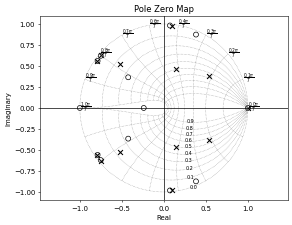

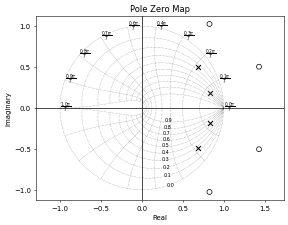

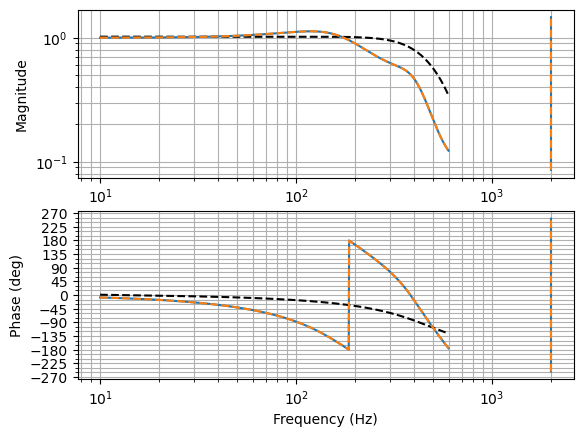

In [26]:
param, statgain = TF2parvec(DL_TF)
atf = parvec2TF(param, dcgain=statgain)
# atf = control.zpk(DL_TF.zeros(), DL_TF.poles(), 1., dt=z_control.dt)
# atf = control.zpk(atf.zeros(), atf.poles(), 1/atf.dcgain(), dt=z_control.dt)
plt.figure(dpi=50)
control.pzmap(raw_bcddl_piezo_fo13.sample(Ts=z_control.dt, method="bilinear"), grid=True)
plt.show()
plt.figure(dpi=50)
control.pzmap(DL_TF, grid=True)
plt.show()
plt.figure(dpi=100)
dump = control.bode_plot(raw_bcddl_piezo_fo13, label="BCDDL", omega_limits=omega_limits,
                         Hz=True, wrap_phase=True, color="k", linestyle="--")
dump = control.bode_plot(DL_TF, label="BCDDL", omega_limits=omega_limits, Hz=True, wrap_phase=True)
dump = control.bode_plot(atf, label="BCDDL", omega_limits=omega_limits, Hz=True, wrap_phase=True, linestyle="--")

/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:494: RuntimeWarning: Number of calls to function has reached maxfev = 1800.
  warnings.warn(errors[info][0], RuntimeWarning)


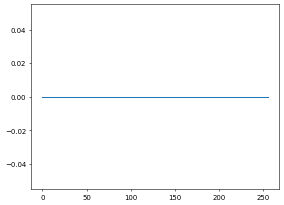

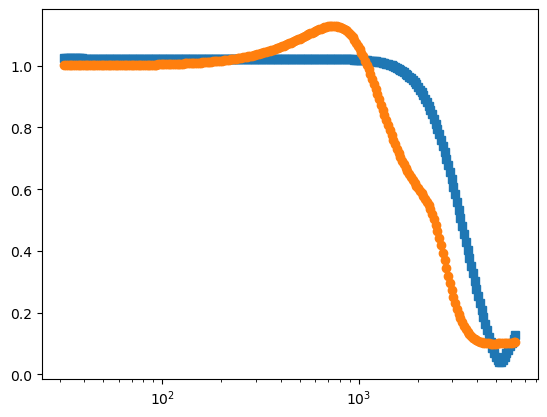

(256,)
(256,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


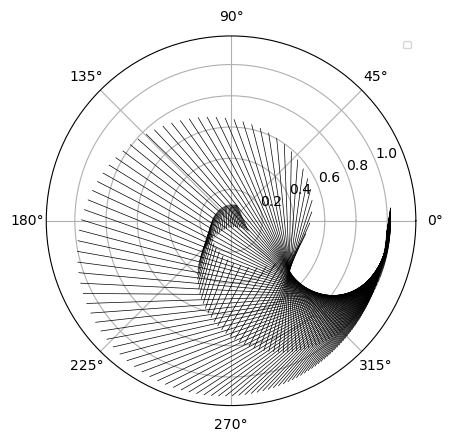

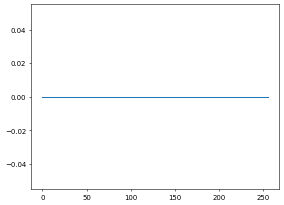

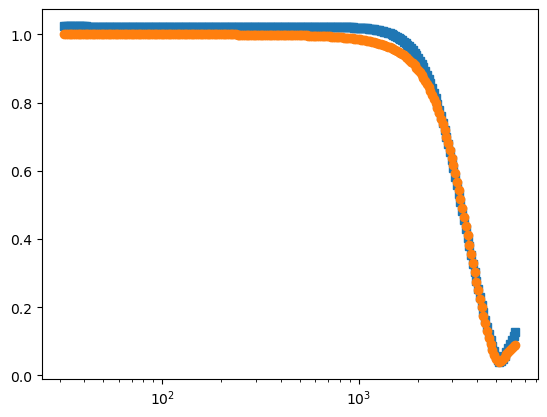

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(256,)
(256,)


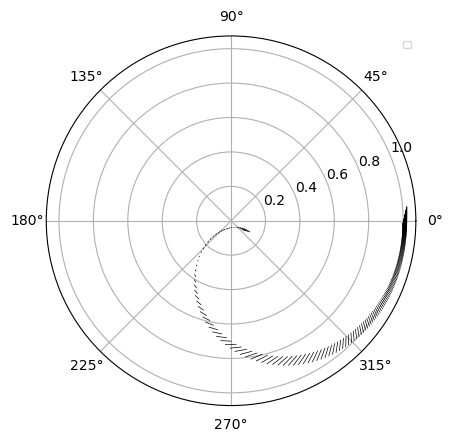

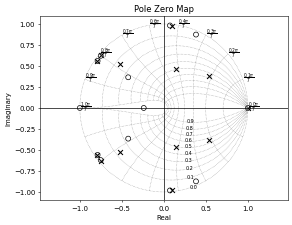

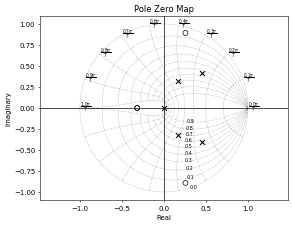

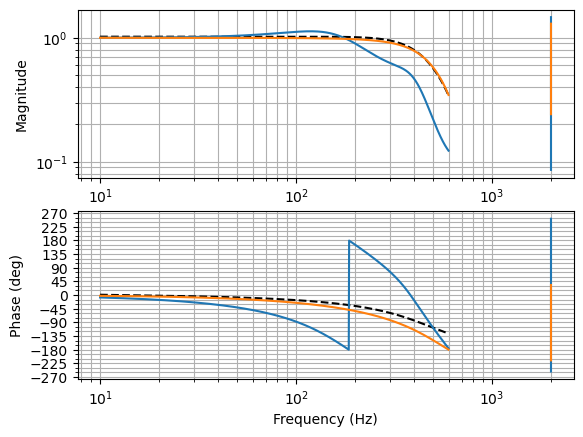

In [27]:
from scipy.optimize import leastsq
param_0, dcgain_0 = TF2parvec(DL_TF)
param_0 = param_0[:]

mymask_o13 = (o13_freqs<=1000) * (o13_freqs>=5.)
fixed_dc_gain = 1. # np.abs(o13_cgain[mymask_o13])[0]

res = leastsq(TF_res, param_0, args=(o13_freqs[mymask_o13], o13_cgain[mymask_o13], fixed_dc_gain))
TF_res(param_0, o13_freqs[mymask_o13], o13_cgain[mymask_o13], verbose=True)
TF_res(res[0], o13_freqs[mymask_o13], o13_cgain[mymask_o13], verbose=True)
fitted_ffw_bcddlt_fo13 = 1/z_control * parvec2TF(parvec=res[0], dt=z_control.dt, dcgain=fixed_dc_gain)

plt.figure(dpi=50)
control.pzmap(raw_bcddl_piezo_fo13.sample(Ts=z_control.dt, method="bilinear"), grid=True)
plt.figure(dpi=50)
control.pzmap(fitted_ffw_bcddlt_fo13, grid=True)

plt.figure()
dump = control.bode_plot(raw_bcddl_piezo_fo13, label="BCDDL", omega_limits=omega_limits,
                         Hz=True, wrap_phase=True, color="k", linestyle="--")
dump = control.bode_plot(DL_TF, label="BCDDL", omega_limits=omega_limits, Hz=True, wrap_phase=True)
dump = control.bode_plot(fitted_ffw_bcddlt_fo13, label="BCDDL", omega_limits=omega_limits, Hz=True, wrap_phase=True, linestyle="-")
plt.show()

# Model for the direct piezo mode (FFW = bypass)

## Bypass model from the commissioning (April 2024)


In [28]:
# bcddl_data_path = "data/bcddl/PiezoResponse/ddl1_Probe_2024-04-22T14-51-30.076143.dat"
bcddl_list = glob.glob("data/bcddl/PiezoResponse/ddl*.dat")
print(bcddl_list)
nps_pz = 4000
freqs = []
tfs = []
cohs = []
for adatapath in bcddl_list:
    data = np.loadtxt(adatapath, dtype=[('timestamp', 'M8[us]'), ('setpoint', float), ('fforward', float), ('metrology', float), ('error', float), ('stage', float), ('piezo', float)])
    setpoint = data['setpoint']
    metrology = np.roll(data['metrology'], -1)
    dt = np.round(np.mean(np.diff(data['timestamp']).astype(float)))/1e6
    
    # Compute transfer function
    freq, Pxy = sig.csd(setpoint, metrology, fs=1/dt, nperseg=nps_pz)
    freq, Pxx = sig.welch(setpoint, fs=1/dt, nperseg=nps_pz)
    freq, coh = sig.coherence(setpoint, metrology, fs=1/dt, nperseg=nps_pz)
    cohs.append(coh)
    tf = Pxy/Pxx
    freqs.append(freq)
    tfs.append(tf)
freqs = np.array(freqs)
tfs = np.array(tfs)
fig = plt.figure()
cohs = np.array(cohs)
meantf = np.average(tfs, axis=0, weights=cohs**6)




['data/bcddl/PiezoResponse/ddl7_Probe_2024-04-22T14-55-25.559990.dat', 'data/bcddl/PiezoResponse/ddl8_Probe_2024-04-22T14-55-53.444994.dat', 'data/bcddl/PiezoResponse/ddl5_Probe_2024-04-22T14-54-33.743624.dat', 'data/bcddl/PiezoResponse/ddl2_Probe_2024-04-22T14-51-59.665495.dat', 'data/bcddl/PiezoResponse/ddl3_Probe_2024-04-22T14-53-31.131186.dat', 'data/bcddl/PiezoResponse/ddl4_Probe_2024-04-22T14-54-03.788445.dat', 'data/bcddl/PiezoResponse/ddl1_Probe_2024-04-22T14-51-30.076143.dat', 'data/bcddl/PiezoResponse/ddl6_Probe_2024-04-22T14-54-59.323658.dat']


<Figure size 640x480 with 0 Axes>

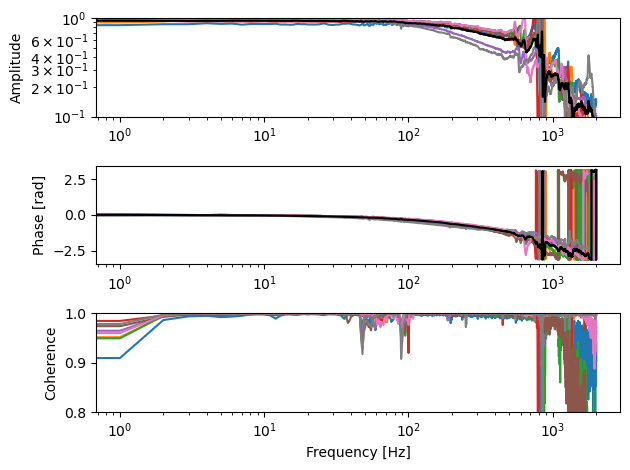

/tmp/ipykernel_124755/762738915.py:31: RuntimeWarning: divide by zero encountered in divide
  delay_func = (tfs)/(2*np.pi)*1/freqs
/tmp/ipykernel_124755/762738915.py:31: RuntimeWarning: invalid value encountered in divide
  delay_func = (tfs)/(2*np.pi)*1/freqs
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(10, 1000)

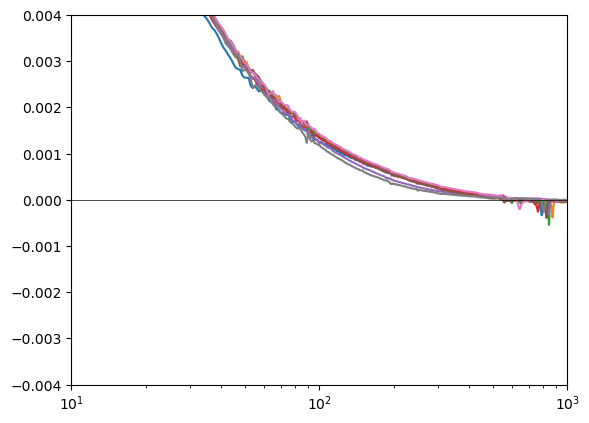

In [29]:
plt.figure()
ax = plt.subplot(311)
for aname, afreq, atf in zip(bcddl_list, freqs, tfs):
    plt.plot(afreq, np.abs(atf))
plt.plot(freqs[0], np.abs(meantf), color="k" )
plt.ylim(0.1, 1.)
plt.xscale("log")
plt.yscale("log")
# plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.subplot(312, sharex=ax)
for aname, afreq, atf in zip(bcddl_list, freqs, tfs):
    plt.plot(afreq, np.angle(atf))
plt.plot(freqs[0], np.angle(meantf), color="k" )
plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase [rad]")

plt.subplot(313, sharex=ax)
for aname, afreq, acoh in zip(bcddl_list, freqs, cohs):
    plt.plot(afreq, acoh)
plt.ylim(0.8, 1.0)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Coherence")
plt.tight_layout()
plt.show()

delay_func = (tfs)/(2*np.pi)*1/freqs
plt.figure()
for afreq, adelay in zip(freqs, delay_func):
    plt.plot(afreq, adelay)
plt.axhline(0, color="k", linewidth=0.5)
plt.xscale("log")
plt.ylim(-0.004, 0.004)
plt.xlim(10, 1000)

/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:494: RuntimeWarning: Number of calls to function has reached maxfev = 2600.
  warnings.warn(errors[info][0], RuntimeWarning)


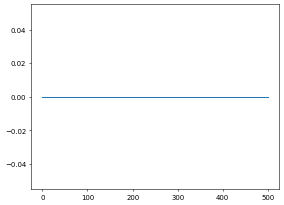

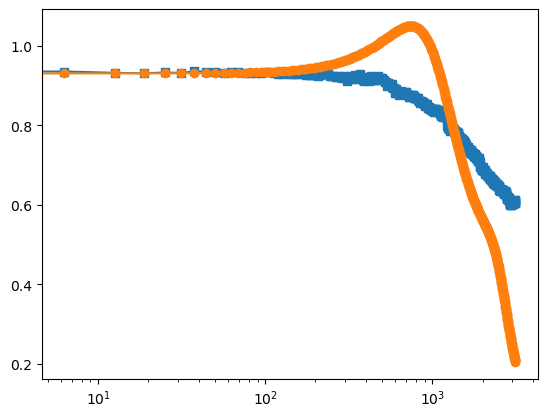

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(501,)
(501,)


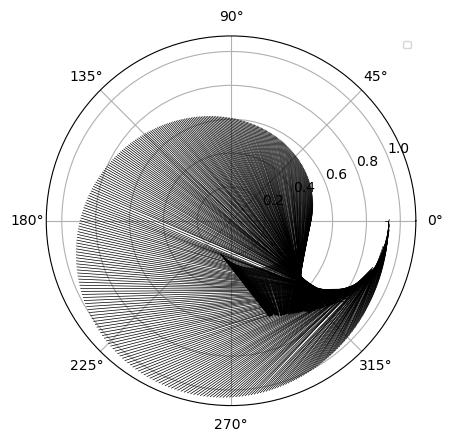

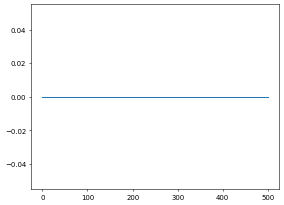

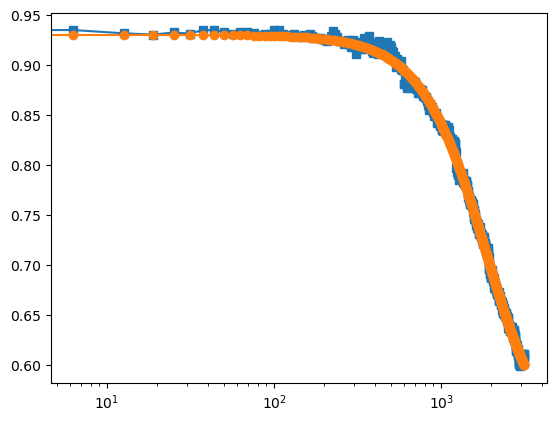

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(501,)
(501,)


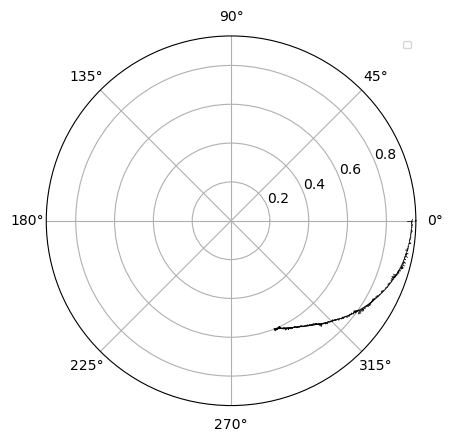

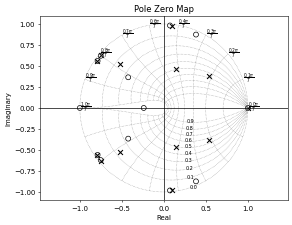

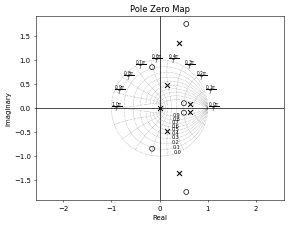

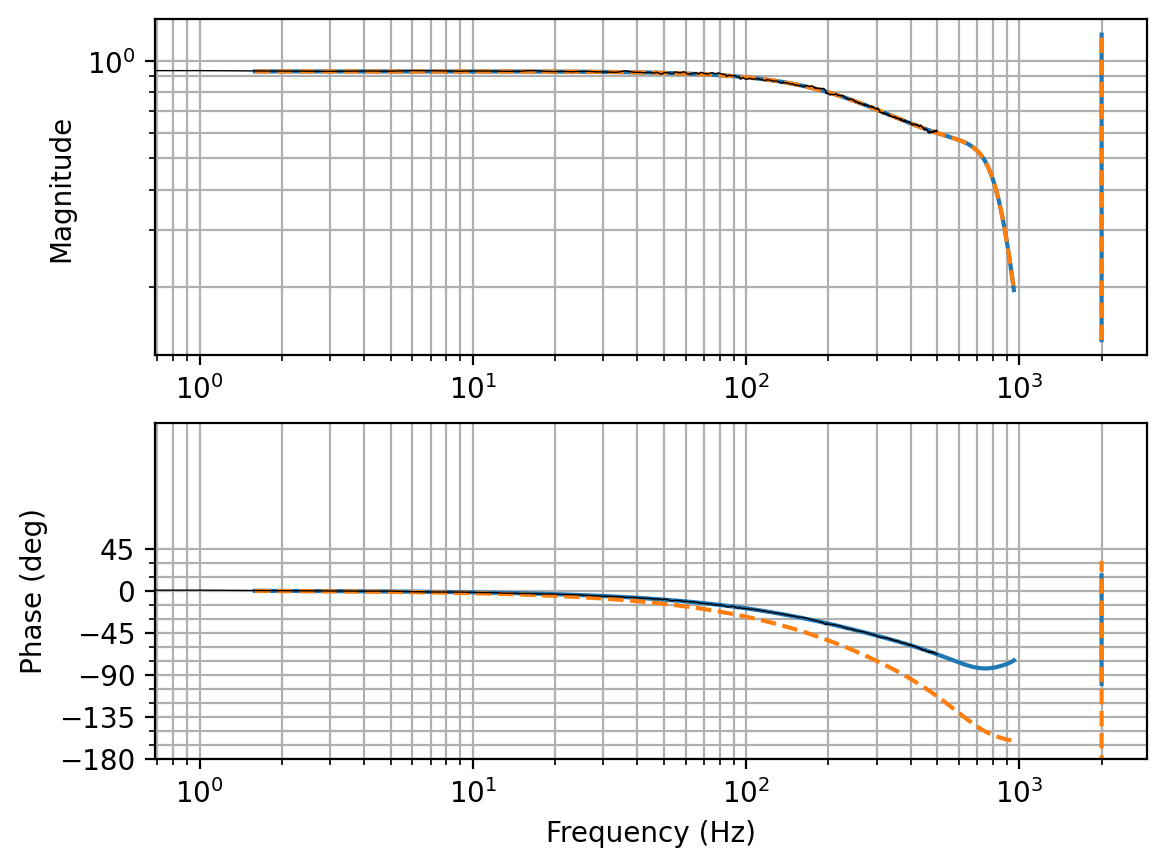

In [30]:
from scipy.optimize import leastsq
param_0, dcgain_0 = TF2parvec(DL_TF)
param_0 = increment_order(param_0)
omega_limits = [10, 6000]


# mymask_bypass = np.mean(cohs, axis=0)>=0.95
myfreqs_piezo = freqs[0].copy()
# myfreqs_piezo[0] = 0.1
# meantf[0] = 0.93
mymask_bypass = myfreqs_piezo<=500
# mymask_bypass[0] = False

fixed_dc_gain = 0.93 # np.abs(meantf)[0]

res = leastsq(TF_res, param_0, args=(myfreqs_piezo[mymask_bypass], meantf[mymask_bypass], fixed_dc_gain))
TF_res(param_0, myfreqs_piezo[mymask_bypass], meantf[mymask_bypass], dcgain=fixed_dc_gain, verbose=True)
TF_res(res[0], myfreqs_piezo[mymask_bypass], meantf[mymask_bypass], dcgain=fixed_dc_gain,  verbose=True)
fitted_ffw_bcddl_nolag = parvec2TF(parvec=res[0], dt=z_control.dt, dcgain=fixed_dc_gain)
fitted_ffw_bcddl = 1/z_control * fitted_ffw_bcddl_nolag

plt.figure(dpi=50)
control.pzmap(raw_bcddl_piezo_fo13.sample(Ts=z_control.dt, method="bilinear"), grid=True)
plt.figure(dpi=50)
control.pzmap(fitted_ffw_bcddl, grid=True)

plt.figure(dpi=200)
dump = control.bode_plot(fitted_ffw_bcddl_nolag, label="BCDDL", omega_limits=omega_limits, Hz=True, wrap_phase=True, linestyle="-")
dump = control.bode_plot(fitted_ffw_bcddl, label="BCDDL", omega_limits=omega_limits, Hz=True, wrap_phase=True, linestyle="--")
fig = plt.gcf()
plt.sca(fig.axes[0])
plt.plot(myfreqs_piezo[mymask_bypass], np.abs(meantf[mymask_bypass]), color="k", linewidth=0.5)

plt.sca(fig.axes[1])
plt.plot(myfreqs_piezo[mymask_bypass], np.angle(meantf[mymask_bypass])*180/np.pi, color="k", linewidth=0.5)
plt.ylim(-180,180)
plt.show()

Back

In [31]:
from scipy.interpolate import interp1d
def resample(x, y, master, be=True):
    """Just a macro for interp1d"""
    values = interp1d(x, y, fill_value="extrapolate", bounds_error=be, )(master)
    return values
lf_raw = np.loadtxt("data/clean_f.dat")
lf_raw = np.concatenate(([1., 3.0], lf_raw))
ltf = np.loadtxt("data/clean_TF.dat", dtype=np.complex128)
ltf = np.concatenate(([1.0, 1.0], ltf))
ltfa_raw = np.loadtxt("data/clean_TF_amp.dat")
ltfa_raw = np.concatenate(([1.0, 1.0], ltfa_raw))
ltfp_raw = np.loadtxt("data/clean_TF_ph.dat")
ltfp_raw = np.concatenate(([0.0, 0.0], ltfp_raw))
#master_freqs = np.logspace(0.3, 2.77, 20)
#master_freqs = np.linspace(2., 600., 20)
base = 0.995
master_freqs = 1/np.log(base) * np.log(np.linspace(base**2., base**600., 20))
ltf = resample(lf_raw, ltf, master_freqs, be=False)
ltfp = resample(lf_raw, ltfp_raw, master_freqs, be=False)
ltfa = resample(lf_raw, ltfa_raw, master_freqs, be=False)
lf = master_freqs


# Fitting the BCDDL TF

## With the Levy method

/tmp/ipykernel_124755/4025581690.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axarr[0].set_xlim(0, 800)


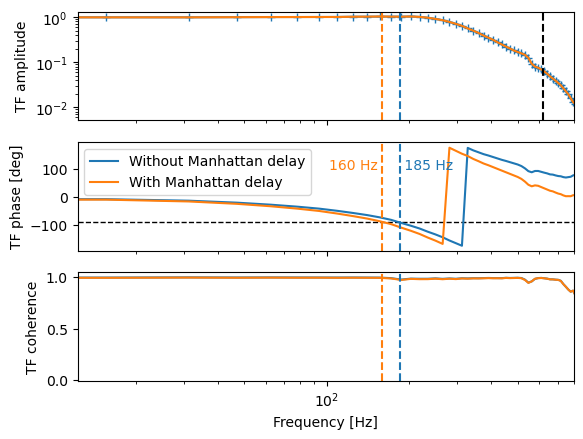

In [32]:
# Code from Julien
timestamp = '2024-01-09T09:02:05.974216'

ddl_col2name = ["Setpoint", "Metrology", "Error", "Stage", "Piezo"]
vib_col2name = ["Setpoint"]
ddl_dtype = [("Setpoint", float), ("Metrology", float), ("Error", float), ("Stage", float), ("Piezo", float)]

# %%

ddl_data = np.loadtxt(f"data/manhattan_transfer_function/manhattan_transfer_function/data/tacRecord_ddl3_{timestamp}.dat", usecols=(1, 2, 3, 4, 5), dtype=ddl_dtype)
vib_data = np.loadtxt(f"data/manhattan_transfer_function/manhattan_transfer_function/data/tacRecord_vib_{timestamp}.dat", usecols=(1,))

# %%

freqj, Cxy1 = sig.coherence(ddl_data['Setpoint'], ddl_data['Metrology'], fs=4000.0)
freqj, Txy1 = sig.csd(ddl_data['Setpoint'], ddl_data['Metrology'], fs=4000.0)
freqj, Txx1 = sig.csd(ddl_data['Setpoint'], ddl_data['Setpoint'], fs=4000.0)
tf1 = Txy1/Txx1

freqj, Cxy2 = sig.coherence(ddl_data['Setpoint'], np.roll(ddl_data['Metrology'], 1), fs=4000.0)
freqj, Txy2 = sig.csd(ddl_data['Setpoint'], np.roll(ddl_data['Metrology'], 1), fs=4000.0)
freqj, Txx2 = sig.csd(ddl_data['Setpoint'], ddl_data['Setpoint'], fs=4000.0)
tf2 = Txy2/Txx2

# %%

fig, axarr = plt.subplots(3, 1, sharex=True)
axarr[1].axhline(-90, color='k', ls='--', lw=1)
axarr[0].plot(freqj, np.abs(tf1), marker="+")
axarr[1].plot(freqj, np.rad2deg(np.angle(tf1)), label="Without Manhattan delay")
axarr[2].plot(freqj, Cxy1)
axarr[0].plot(freqj, np.abs(tf2))
axarr[1].plot(freqj, np.rad2deg(np.angle(tf2)), label="With Manhattan delay")
axarr[2].plot(freqj, Cxy2)
axarr[0].set_xscale("log")
axarr[0].set_yscale("log")
axarr[1].set_xscale("log")

axarr[2].set_xlabel("Frequency [Hz]")
axarr[0].set_ylabel("TF amplitude")
axarr[1].set_ylabel("TF phase [deg]")
axarr[2].set_ylabel("TF coherence")
axarr[0].set_xlim(0, 800)
axarr[1].legend()
for i in range(3):
    axarr[i].axvline(185, ls='--', color='C0')
    axarr[i].axvline(160, ls='--', color='C1')
axarr[1].text(185, 100, ' 185 Hz', ha='left', color='C0')
axarr[1].text(160, 100, '160 Hz ', ha='right', color='C1')
axarr[0].axvline(freqj[-50]/2, ls="--", color="k")
fig.savefig("BCDDL_TF.pdf")
plt.show()

# %%
# 
# fig, axarr = plt.subplots(5, 1, sharex=True)
# for i in range(ddl_data.shape[1]):
#     axarr[i].plot(ddl_data[:, i], label=ddl_col2name[i])
#     axarr[i].legend(loc='upper right')
# plt.show()
# 
# %%



from scipy.linalg import sqrtm
def get_A(cgains, freqs, order):
    """
    Builds the A matrix for a Levy fit of a transfer function based
    on frequency responce
    **Arguments**:
    
    * `cgains` : [array-like] Complex gain vector for each frequency sample
    * `freqs` : [array-like] Frequency samples at which
      the complex gain is provided
    * `order` : [int] The order of the fit
    
    **Returns**: 
    * A : [2d array] the matrix $b = A.x+\epsilon$
    """
    myom = 2*np.pi*freqs
    mys = 1j*myom
    myns = np.arange(order)
    mysa = mys[:,None]**myns[None,:]
    mysb = - cgains[:,None] * mys[:,None]**myns[None,1:]
    # print("mysa",mysa.shape)
    # print("mysb", mysb.shape)
    myA = np.concatenate((mysa, mysb), axis=1)
    return myA

def get_levy(cgain, freqs, order):
    """
    get_levy: 
    Gets the least squares fit of a transfer function
    based on the frequency response using the Levy method.

    **Arguments** :

    * `cgains` : [array-like] Complex gain vector for each frequency sample
    * `freqs` : [array-like] Frequency samples at which
      the complex gain is provided
    * `order` : [int] The order of the fit

    **returns** : 
    * a `control.TransferFunction` object containing the fitted TF.
    """
    A = get_A(cgain, freqs, order)
    B = np.linalg.inv((A.T.dot(A))).dot(A.T)
    myx = B.dot(cgain)
    mynum = np.flip(myx[:order])
    myden = np.flip(np.concatenate(([1], myx[order:])))
    mytf = control.tf(mynum, myden)
    return mytf

def get_weighted_levy(cgain, freqs, order, sig):
    """
    get_weighted_levy: 
    Gets the least squares fit of a transfer function
    based on the frequency response, with a weighted Levy method

    **Arguments** :

    * `cgains` : [array-like] Complex gain vector for each frequency sample
    * `freqs` : [array-like] Frequency samples at which
      the complex gain is provided
    * `order` : [int] The order of the fit
    * `sig`   : [numpy array] standard deviation of the frequency samples

    **returns** : 
    * a `control.TransferFunction` object containing the fitted TF.
    """
    if len(sig.shape) == 2:
        # Covariance matrix
        Sigma = sig
    elif len(sig.shape) == 1:
        # Standard deviations
        Sigma = np.diag(sig**2)
    else:
        raise ValueError("Wrong dimension for sig")
    W = sqrtm(np.linalg.inv(Sigma))
    A = get_A(cgain, freqs, order)
    B = np.linalg.inv((A.T.dot(W.dot(A)))).dot(A.T)
    myx = B.dot(W.dot(cgain))
    mynum = np.flip(myx[:order])
    myden = np.flip(np.concatenate(([1], myx[order:])))
    mytf = control.tf(mynum, myden)
    return mytf


/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/control/xferfcn.py:1083: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/control/xferfcn.py:1113: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


TransferFunction(array([-3.03981157e-08-3.97349374e-08j, -2.01197758e-04+3.38536157e-04j,
        9.38041542e-01-3.31055289e-02j]), array([1.27450027e-07+3.03558655e-07j, 8.43663329e-04+5.53594695e-04j,
       1.00000000e+00+0.00000000e+00j]))

TransferFunction(array([ 1.13314620e-11-6.74683469e-12j, -1.10945884e-07-9.87145803e-08j,
       -1.97420264e-04+5.76410141e-04j,  9.56349615e-01-9.69374880e-03j]), array([-1.08731557e-10+6.81328040e-11j,  8.43451016e-08+6.70739829e-07j,
        9.89633533e-04+7.62704490e-04j,  1.00000000e+00+0.00000000e+00j]))

TransferFunction(array([ 6.04952890e-15+7.10947192e-15j,  6.88048289e-11-9.89728225e-11j,
       -5.65616613e-07-1.80643520e-07j, -9.81735680e-05+1.30080382e-03j,
        9.50471774e-01-9.13568853e-03j]), array([-4.84615470e-14-8.21520949e-14j, -6.33670869e-10+1.17724302e-10j,
       -5.34248530e-07+1.51206813e-06j,  1.07902545e-03+1.58484356e-03j,
        1.00000000e+00+0.00000000e+00j]))

TransferFunction(array([-2.60405849e-18+3.47999144e-18j,  6.00087838e-14+2.99269449e-14j,
        1.10676196e-10-4.01134926e-10j, -1.28366171e-06-1.50043872e-07j,
       -5.94336514e-05+1.89874847e-03j,  9.46742512e-01-7.63640817e-03j]), array([ 4.24616336e-17-2.66257018e-17j, -1.24493400e-13-4.47464896e-13j,
       -1.62809052e-09-1.66819223e-10j, -1.53513280e-06+2.36426216e-06j,
        1.12940495e-03+2.27026615e-03j,  1.00000000e+00+0.00000000e+00j]))

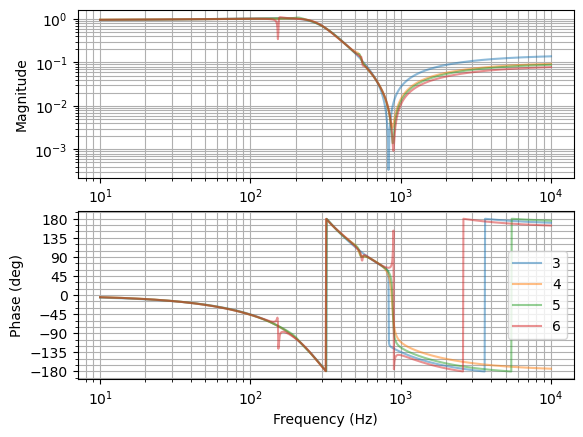

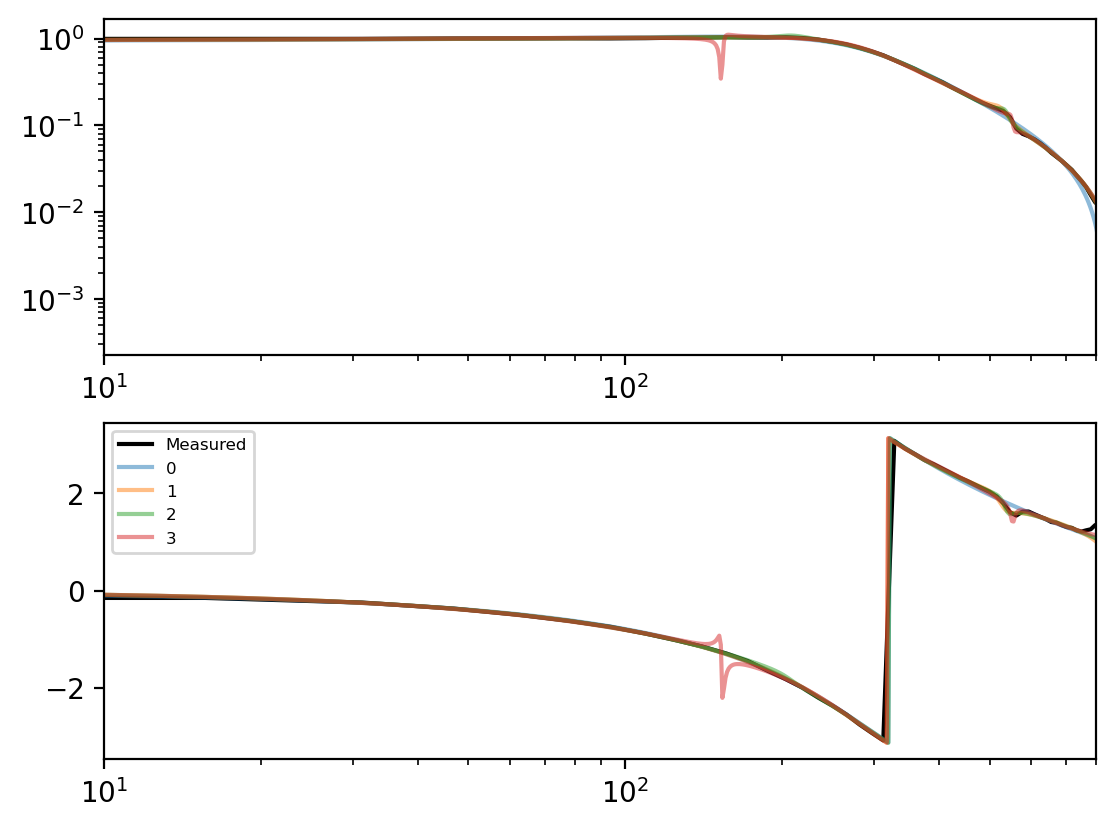

In [33]:

tfs = []
fitmags = []
fitphases = []
fitomegas = []
orders = range(3,7)
skiplast = 30
for i in orders:
    atf = pytac.get_levy(tf1[Cxy1>=0.9], freqj[Cxy1>=0.9], i)
    # atf = pytac.get_weighted_levy(tf1, freqj, i, sig=1/Cxy1**4)
    # atf = pytac.get_levy(tf1[:skiplast], freqj[:skiplast], i)
    mags, phases, omegas = control.bode_plot(atf, Hz=True, label=i, wrap_phase=True, alpha=0.5)
    fitmags.append(mags)
    fitphases.append(phases)
    fitomegas.append(omegas)
    tfs.append(atf)
    display(atf)
    #tf3 = pytac.get_levy(tf1, freqj, 4)
plt.legend()
fitmags = np.array(fitmags)
fitphases = np.array(fitphases)
fitomegas = np.array(fitomegas)


plt.figure(dpi=200)
ax1 = plt.subplot(211)
plt.plot(freqj, np.abs(tf1), color="k", label="Measured")
for i, (anom, amag, aphase) in enumerate(zip(fitomegas, fitmags, fitphases)):
    plt.plot(anom/(2*np.pi), amag, alpha=0.5, color=f"C{i}", label=i)
plt.xlim(10, 8e2)
plt.yscale("log")
plt.xscale("log")
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(freqj, np.angle(tf1), color="k", label="Measured")
for i, (anom, amag, aphase) in enumerate(zip(fitomegas, fitmags, fitphases)):
    plt.plot(anom/(2*np.pi), aphase, alpha=0.5, color=f"C{i}", label=i)
plt.legend(fontsize=6)
plt.show()

mytfs = tfs[1]
mytfz = control.sample_system(mytfs, 250e-6, method="zoh")

## With the iterative method

/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:494: RuntimeWarning: Number of calls to function has reached maxfev = 1800.
  warnings.warn(errors[info][0], RuntimeWarning)


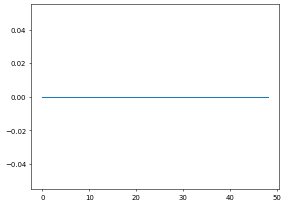

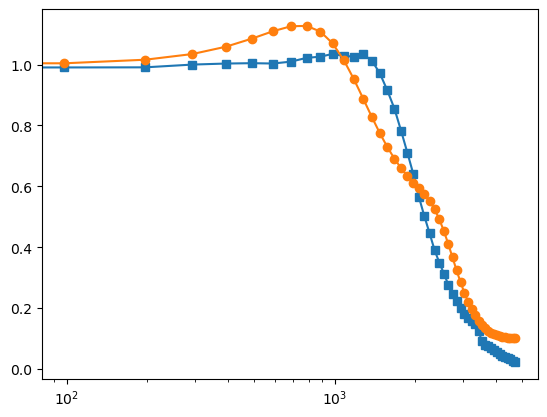

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(49,)
(49,)


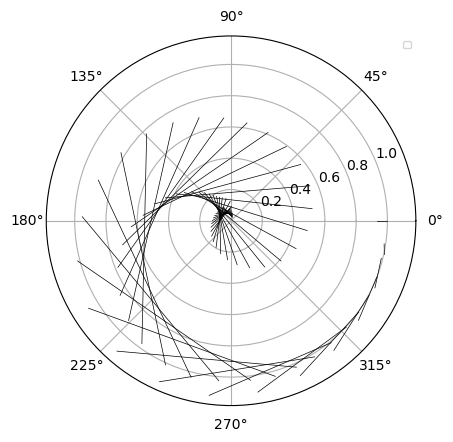

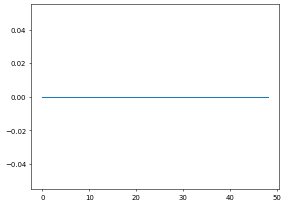

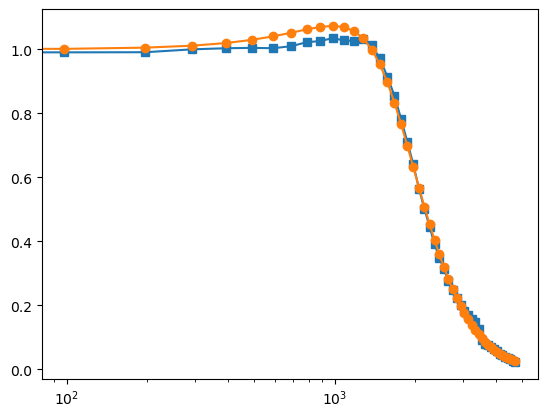

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(49,)
(49,)


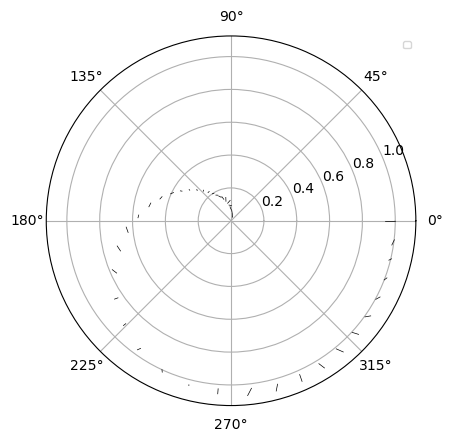

/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:461: LinAlgWarning: Ill-conditioned matrix (rcond=1.04913e-85): result may not be accurate.
  ad = linalg.solve(ima, np.eye(a.shape[0]) + (1.0-alpha)*dt*a)
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:462: LinAlgWarning: Ill-conditioned matrix (rcond=1.04913e-85): result may not be accurate.
  bd = linalg.solve(ima, dt*b)
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.02124e-85): result may not be accurate.
  cd = linalg.solve(ima.transpose(), c.transpose())


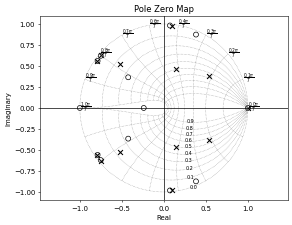

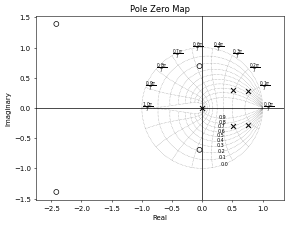

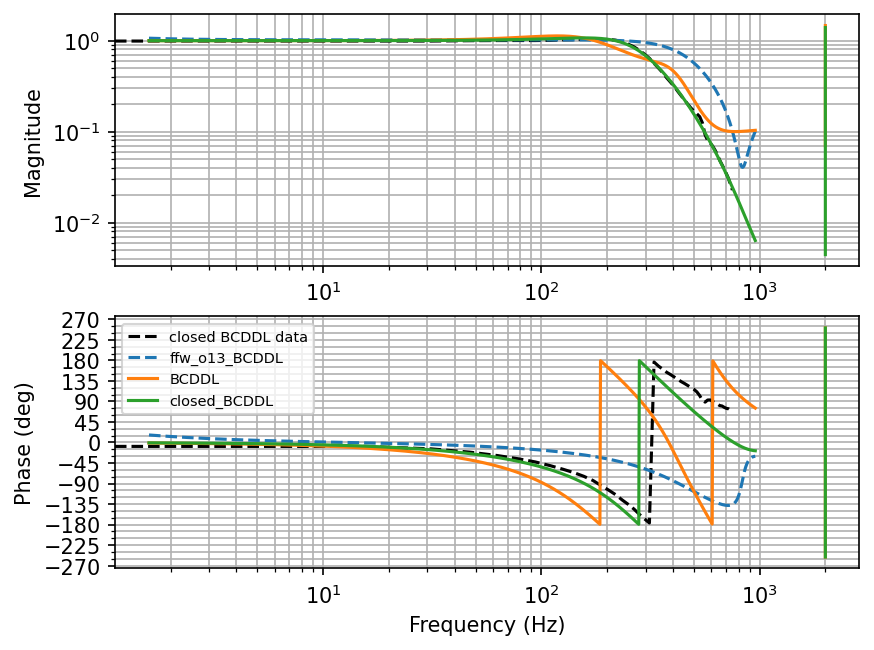

In [34]:
from scipy.optimize import leastsq
param_0, dcgain_0 = TF2parvec(DL_TF)
param_0 = param_0[:]

mymask_bcddl = Cxy1>=0.9 
fixed_dc_gain = 1. # np.abs(o13_cgain[mymask_o13])[0]

res = leastsq(TF_res, param_0, args=(freqj[mymask_bcddl], tf1[mymask_bcddl], fixed_dc_gain))
TF_res(param_0, freqj[mymask_bcddl], tf1[mymask_bcddl], verbose=True)
TF_res(res[0], freqj[mymask_bcddl], tf1[mymask_bcddl], verbose=True)
nolag_fitted_closed_bcddl = parvec2TF(parvec=res[0], dt=z_control.dt, dcgain=fixed_dc_gain)
fitted_closed_bcddl = 1/z_control * nolag_fitted_closed_bcddl
# fitted_closed_bcddl = nolag_fitted_closed_bcddl

plt.figure(dpi=50)
control.pzmap(raw_bcddl_piezo_fo13.sample(Ts=z_control.dt, method="bilinear"), grid=True)
plt.figure(dpi=50)
control.pzmap(fitted_closed_bcddl, grid=True)

plt.figure(dpi=150)
fresp_closed_bcddl = control.FrequencyResponseData(tf1[mymask_bcddl], (2*np.pi)*freqj[mymask_bcddl])
dump = control.bode_plot(fresp_closed_bcddl, (2*np.pi)*freqj[mymask_bcddl], label="closed BCDDL data",
                         Hz=True, wrap_phase=True, color="k", linestyle="--")
dump = control.bode_plot(raw_bcddl_piezo_fo13, label="ffw_o13_BCDDL", omega_limits=omega_limits,
                         Hz=True, wrap_phase=True, linestyle="--")
dump = control.bode_plot(DL_TF, label="BCDDL", omega_limits=omega_limits, Hz=True, wrap_phase=True)
dump = control.bode_plot(fitted_closed_bcddl, label="closed_BCDDL", omega_limits=omega_limits, Hz=True, wrap_phase=True, linestyle="-")
plt.legend(fontsize=7)
plt.show()

In [35]:

# with open("data/fitted_BCDDL_TF.p", "wb") as afile:
#     pickle.dump(mytfz, afile)

<module 'pickle' from '/lhome/romain/miniconda3/envs/control2/lib/python3.9/pickle.py'>

# Re-fitting the main DL model:

## With the Levy method

TransferFunction(array([-1.47764350e-07-5.74734811e-08j, -8.54137219e-05+7.71960560e-04j,
        8.16900774e-01-2.59732711e-01j]), array([-3.46594806e-07+2.84017037e-07j,  6.08304564e-04+1.37116894e-03j,
        1.00000000e+00+0.00000000e+00j]))

TransferFunction(array([ 4.50857630e-11-5.62391211e-11j, -4.58032152e-07-2.55528211e-07j,
       -3.13022101e-04+1.17294331e-03j,  9.16815232e-01-1.32694040e-01j]), array([-1.37932282e-10-1.07653852e-10j, -7.70138676e-07+6.87818682e-07j,
        8.27355270e-04+1.68398647e-03j,  1.00000000e+00+0.00000000e+00j]))

TransferFunction(array([ 1.62240245e-15+2.28217163e-14j,  2.18196924e-10-7.65082182e-11j,
       -5.30064303e-07-6.72334478e-07j, -6.67891526e-04+1.24408109e-03j,
        9.51498144e-01-3.62086827e-03j]), array([-1.68492012e-14-7.08099645e-14j, -5.89318178e-10-6.17192880e-11j,
       -8.17507517e-07+1.52205463e-06j,  1.24214494e-03+1.78020358e-03j,
        1.00000000e+00+0.00000000e+00j]))

TransferFunction(array([-1.21967918e-17+2.68160471e-18j,  6.16813902e-14+1.37868812e-13j,
        5.62028634e-10-4.32975542e-10j, -1.31182804e-06-9.79283860e-07j,
       -6.14427407e-04+1.81606914e-03j,  9.47841521e-01-9.49213105e-04j]), array([ 4.78557885e-17-7.99623747e-18j,  3.80589316e-14-4.67089914e-13j,
       -1.62493637e-09-6.09416410e-10j, -1.96948019e-06+2.41274601e-06j,
        1.29950647e-03+2.42854654e-03j,  1.00000000e+00+0.00000000e+00j]))

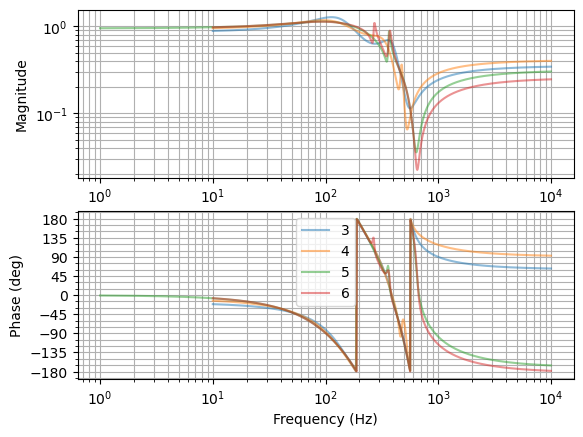

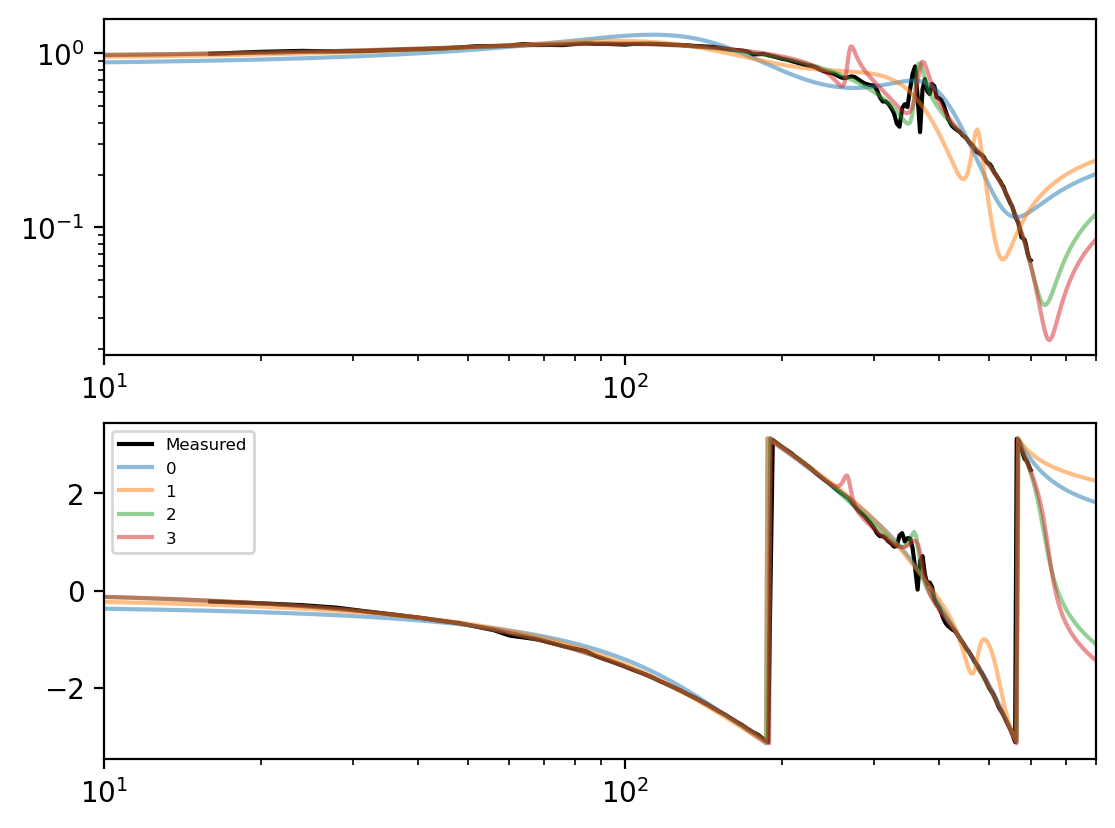

In [36]:
dl_freqs = np.loadtxt("data/clean_f.dat")
dl_tf = np.loadtxt("data/clean_TF.dat", dtype="complex")
tfs = []
fitmags = []
fitphases = []
fitomegas = []
orders = range(3,7)
skiplast = 30
for i in orders:
    atf = pytac.get_levy(dl_tf, dl_freqs, i)
    # atf = pytac.get_weighted_levy(dl_tf, dl_freqs, i, sig=1/Cxy1**4)
    # atf = pytac.get_levy(dl_tf[:skiplast], dl_freqs[:skiplast], i)
    mags, phases, omegas = control.bode_plot(atf, Hz=True, label=i, wrap_phase=True, alpha=0.5)
    fitmags.append(mags)
    fitphases.append(phases)
    fitomegas.append(omegas)
    tfs.append(atf)
    display(atf)
    #tf3 = pytac.get_levy(dl_tf, dl_freqs, 4)
plt.legend()
fitmags = np.array(fitmags)
fitphases = np.array(fitphases)
fitomegas = np.array(fitomegas)


plt.figure(dpi=200)
ax1 = plt.subplot(211)
plt.plot(dl_freqs, np.abs(dl_tf), color="k", label="Measured")
for i, (anom, amag, aphase) in enumerate(zip(fitomegas, fitmags, fitphases)):
    plt.plot(anom/(2*np.pi), amag, alpha=0.5, color=f"C{i}", label=i)
plt.xlim(10, 8e2)
plt.yscale("log")
plt.xscale("log")
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(dl_freqs, np.angle(dl_tf), color="k", label="Measured")
for i, (anom, amag, aphase) in enumerate(zip(fitomegas, fitmags, fitphases)):
    plt.plot(anom/(2*np.pi), aphase, alpha=0.5, color=f"C{i}", label=i)
plt.legend(fontsize=6)
plt.show()

my_dl_tf = tfs[1]
my_dl_tfz = control.sample_system(my_dl_tf, 250e-6, method="zoh")

# Fitting the BCDDL

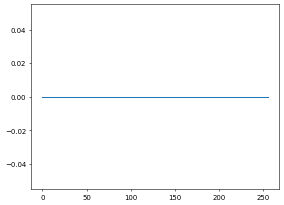

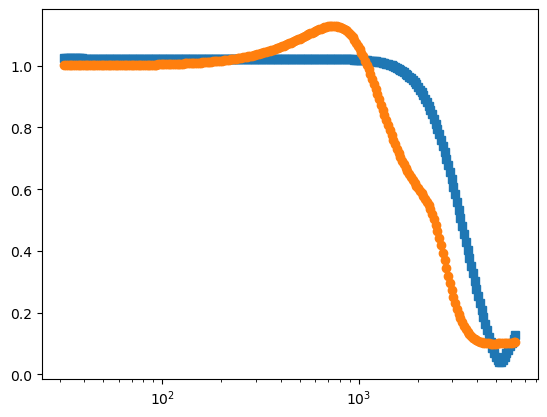

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(256,)
(256,)


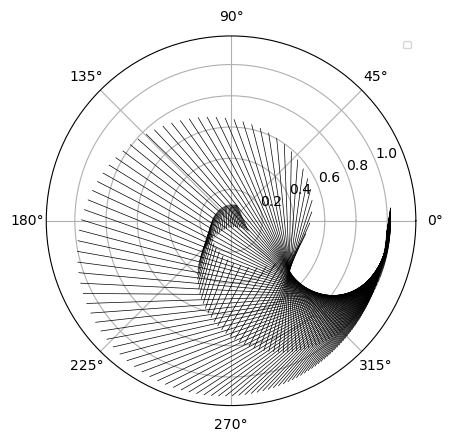

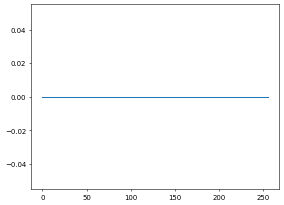

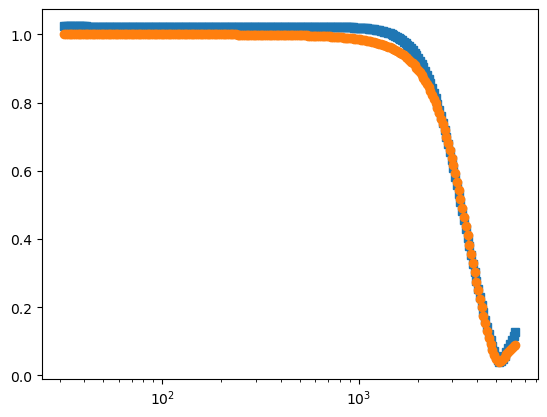

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(256,)
(256,)


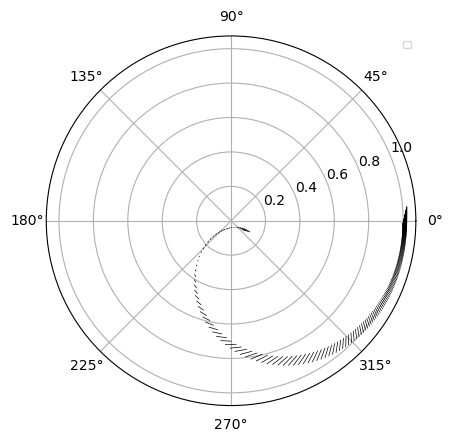

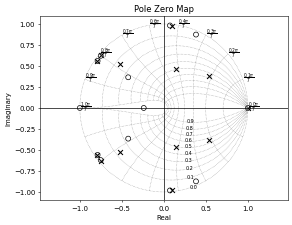

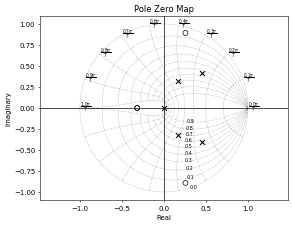

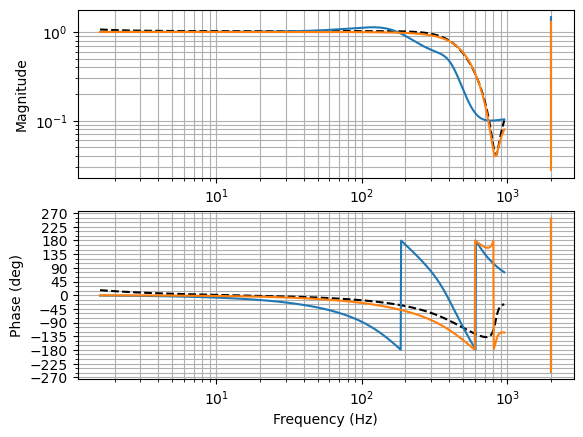

In [37]:
from scipy.optimize import leastsq
param_0, dcgain_0 = TF2parvec(DL_TF)
param_0 = param_0[:]

mymask_o13 = (o13_freqs<=1000) * (o13_freqs>=5.)
fixed_dc_gain = 1. # np.abs(o13_cgain[mymask_o13])[0]

res = leastsq(TF_res, param_0, args=(o13_freqs[mymask_o13], o13_cgain[mymask_o13], fixed_dc_gain))
TF_res(param_0, o13_freqs[mymask_o13], o13_cgain[mymask_o13], verbose=True)
TF_res(res[0], o13_freqs[mymask_o13], o13_cgain[mymask_o13], verbose=True)
fitted_ffw_bcddlt_fo13 = 1/z_control * parvec2TF(parvec=res[0], dt=z_control.dt, dcgain=fixed_dc_gain)

plt.figure(dpi=50)
control.pzmap(raw_bcddl_piezo_fo13.sample(Ts=z_control.dt, method="bilinear"), grid=True)
plt.figure(dpi=50)
control.pzmap(fitted_ffw_bcddlt_fo13, grid=True)

plt.figure()
dump = control.bode_plot(raw_bcddl_piezo_fo13, label="BCDDL", omega_limits=omega_limits,
                         Hz=True, wrap_phase=True, color="k", linestyle="--")
dump = control.bode_plot(DL_TF, label="BCDDL", omega_limits=omega_limits, Hz=True, wrap_phase=True)
dump = control.bode_plot(fitted_ffw_bcddlt_fo13, label="BCDDL", omega_limits=omega_limits, Hz=True, wrap_phase=True, linestyle="-")
plt.show()

In [38]:
pickle
# with open("data/fitted_DL_TF_2.p", "wb") as afile:
#     pickle.dump(my_dl_tfz, afile)

<module 'pickle' from '/lhome/romain/miniconda3/envs/control2/lib/python3.9/pickle.py'>

# Fitting mah->bcdd tf (2024-10-23)

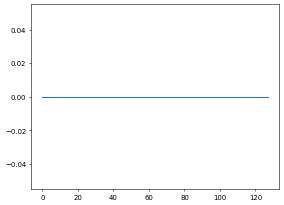

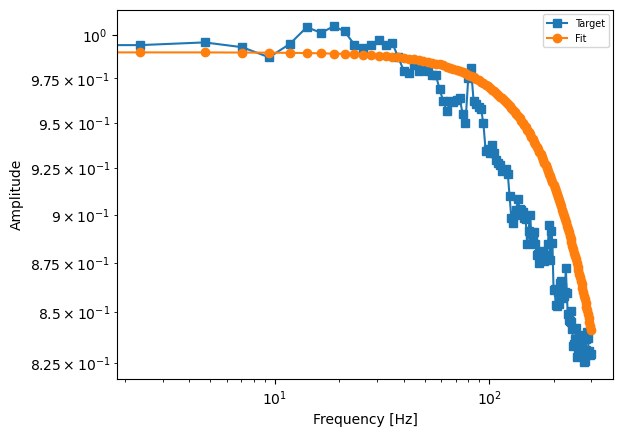

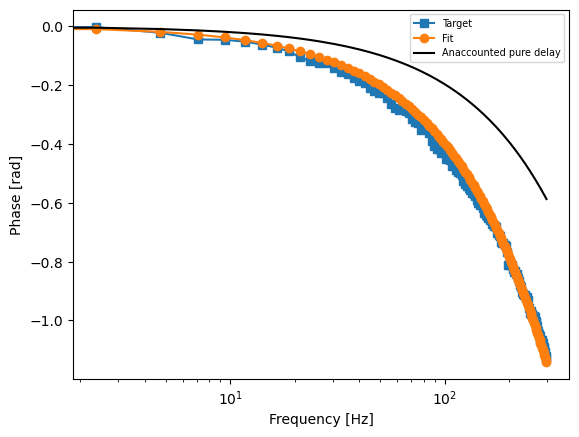

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(128,)
(128,)


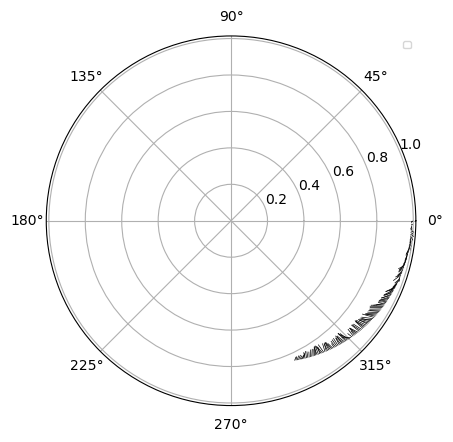

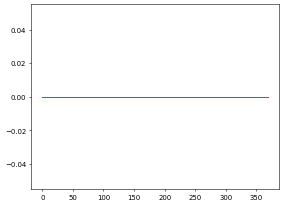

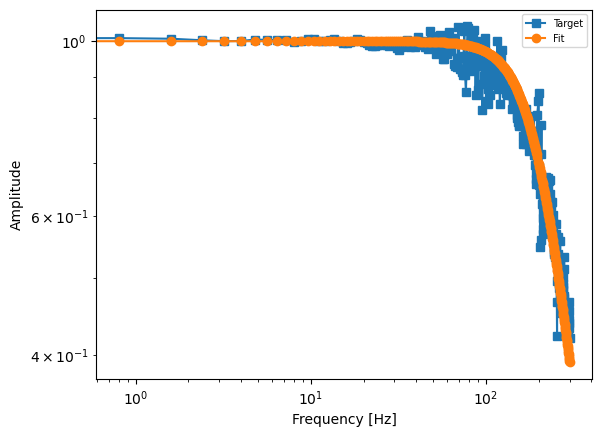

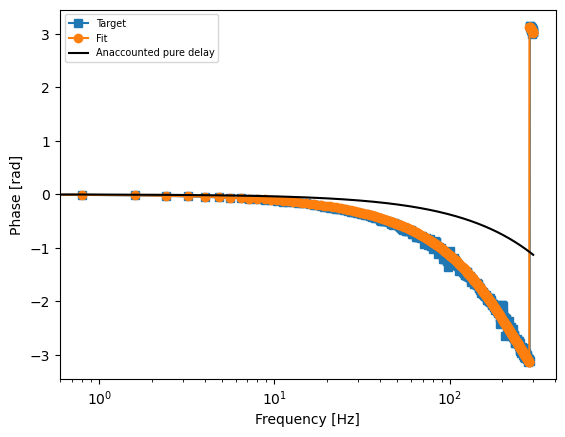

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(370,)
(370,)


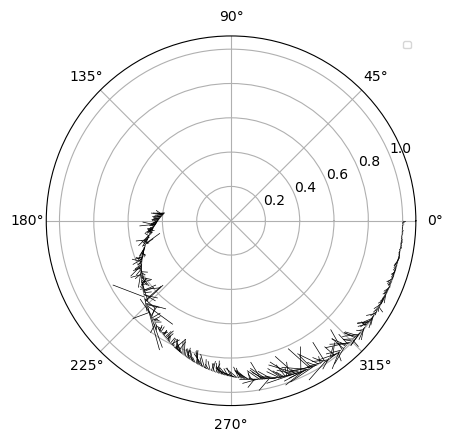

In [62]:


from lmfit import Parameters, minimizer, minimize 
    
def low_pass_fit_res(tfparams, target_f_0, target_TF_0, lp_order,
                     fmax=3.0e2, delay_cycles=0,
                    verbose=False):
    freq_mask = target_f_0 <= fmax
    target_f = target_f_0[freq_mask]
    target_TF = target_TF_0[freq_mask]
    dcgain = tfparams["dcgain"].value
    thefilter_0 = sig.butter(lp_order, tfparams["fcut"], btype="lowpass", output="ba", fs=1/z_control.dt)
    thefilter = 1/z_control**delay_cycles * dcgain * control.tf(*thefilter_0, dt=z_control.dt)
    fig = plt.figure()
    amag, aph, om = control.bode_plot(thefilter, omega=(2*np.pi)*target_f, Hz=True, dB=False, plot=False,
                                     wrap_phase=False)
    plt.close()
    extra_phase = tfparams["Pure_delay"] * 2*np.pi * target_f
    
    sampled_cpx = amag*np.exp(1j*(aph + extra_phase))
    if verbose:
        plt.figure(dpi=50)
        plt.plot(om - (2*np.pi)*target_f)
        plt.show()
        
    #print(amag.shape)
    if verbose:
        plt.figure(dpi=100)
        # plt.plot(target_f, target_TF, marker="s")
        plt.plot(target_f, np.abs(target_TF), marker="s",label="Target")
        plt.plot(om/(2*np.pi), amag, marker="o", label="Fit")
        plt.legend(fontsize=7)
        plt.xscale("log")
        plt.yscale("log")
        plt.ylabel("Amplitude")
        plt.xlabel("Frequency [Hz]")
        plt.show()
        
        plt.figure(dpi=100)
        # plt.plot(target_f, target_TF, marker="s")
        plt.plot(target_f, np.angle(target_TF), marker="s",label="Target")
        plt.plot(om/(2*np.pi), np.angle(sampled_cpx), marker="o", label="Fit")
        plt.plot(om/(2*np.pi), extra_phase, color="k", label="Anaccounted pure delay")
        plt.legend(fontsize=7)
        plt.xscale("log")
        plt.ylabel("Phase [rad]")
        plt.xlabel("Frequency [Hz]")
        plt.show()
    if verbose:
        plt.figure(dpi=100)
        # plt.polar(np.angle(cpx_res), np.abs(cpx_res), label="Res")
        print(np.angle(target_TF).shape)
        print(np.abs(target_TF).shape)
        # plt.polar(np.angle(target_TF), np.abs(target_TF),amag,marker="o", label="target")
        # plt.polar(aph, amag, marker="o", label="Raw fit")
        for astart, aend in zip(target_TF, sampled_cpx):
            plt.polar([np.angle(astart), np.angle(aend)],[np.abs(astart),np.abs(aend)],
                      color="k", linewidth=0.5)
        # plt.polar(np.angle(sampled_cpx), amag, label="fit")
        plt.legend(fontsize="x-small")
        plt.show()
    # resr = (np.real(sampled_cpx) - np.real(target_TF))**2
    # resi = (np.imag(sampled_cpx) - np.imag(target_TF))**2
    res = np.abs(1- (sampled_cpx / target_TF)) #/np.abs(target_TF)
    # res = np.array([resr, resi]).flatten()
    # res = np.abs(sampled_cpx - target_TF)
    if verbose:
        return res, thefilter
    return res


# mahbcddl_ffw_f = np.loadtxt("data/tfs/mah_ddl1_bypass_f.dat")
# mahbcddl_ffw = np.loadtxt("data/tfs/mah_ddl1_bypass_amp.dat", dtype=complex)
# mahbcddl_ffw_f = np.loadtxt("data/tfs/tf_f_ffw_1kHz_2024-12-12.dat")
# mahbcddl_ffw = np.loadtxt("data/tfs/tf_a_ffw_1kHz_2024-12-12.dat", dtype=complex)
mahbcddl_ffw_f = np.loadtxt("data/manhattan_transfer_function/bcddl_tf_2024-12-13_internal/BCDDL/clean_f_2024-12-13_ffw1.dat")
mahbcddl_ffw = np.loadtxt("data/manhattan_transfer_function/bcddl_tf_2024-12-13_internal/BCDDL/clean_a_2024-12-13_ffw1.dat", dtype=complex)

lp_param = Parameters()
lp_param.add(name="fcut", value=100., min=50., max=1000.)
lp_param.add(name="Pure_delay", value=0.0e-3, min=-5.0e-3, max=5.0e-3)
lp_param.add(name="dcgain", value=0.99, min=0.1, max=2.0,vary=False)
res_ffw = minimize(low_pass_fit_res, lp_param, args=[mahbcddl_ffw_f, mahbcddl_ffw, 1,], kws={"fmax":5.0e2})
residual, fitted_lowpass_bypass = low_pass_fit_res(res_ffw.params, mahbcddl_ffw_f, mahbcddl_ffw, 1, verbose=True)
fitted_lowpass_bypass_delay = z_control**(int(np.round(res_ffw.params["Pure_delay"].value/z_control.dt)))
display(res_ffw)

with open("data/fitted_lowpass_bypass.p", "wb") as afile:
    pickle.dump(fitted_lowpass_bypass, afile)

mahbcddl_servo_f = np.loadtxt("data/tfs/mah_ddl1_servo_f.dat")
mahbcddl_servo = np.loadtxt("data/tfs/mah_ddl1_servo_amp.dat", dtype=complex)

lp_param = Parameters()
lp_param.add(name="fcut", value=200., min=50., max=1000.)
lp_param.add(name="Pure_delay", value=0.0e-3, min=-5.0e-3, max=5.0e-3)
lp_param.add(name="dcgain", value=1.0, min=0.1, max=2.0, vary=False)
res_servo = minimize(low_pass_fit_res, lp_param, args=[mahbcddl_servo_f, mahbcddl_servo, 2,])
residual, fitted_lowpass_servo = low_pass_fit_res(res_servo.params, mahbcddl_servo_f, mahbcddl_servo, 2, verbose=True)
fitted_lowpass_servo_delay = z_control**(int(np.round(res_servo.params["Pure_delay"].value/z_control.dt)))
display(res_servo)

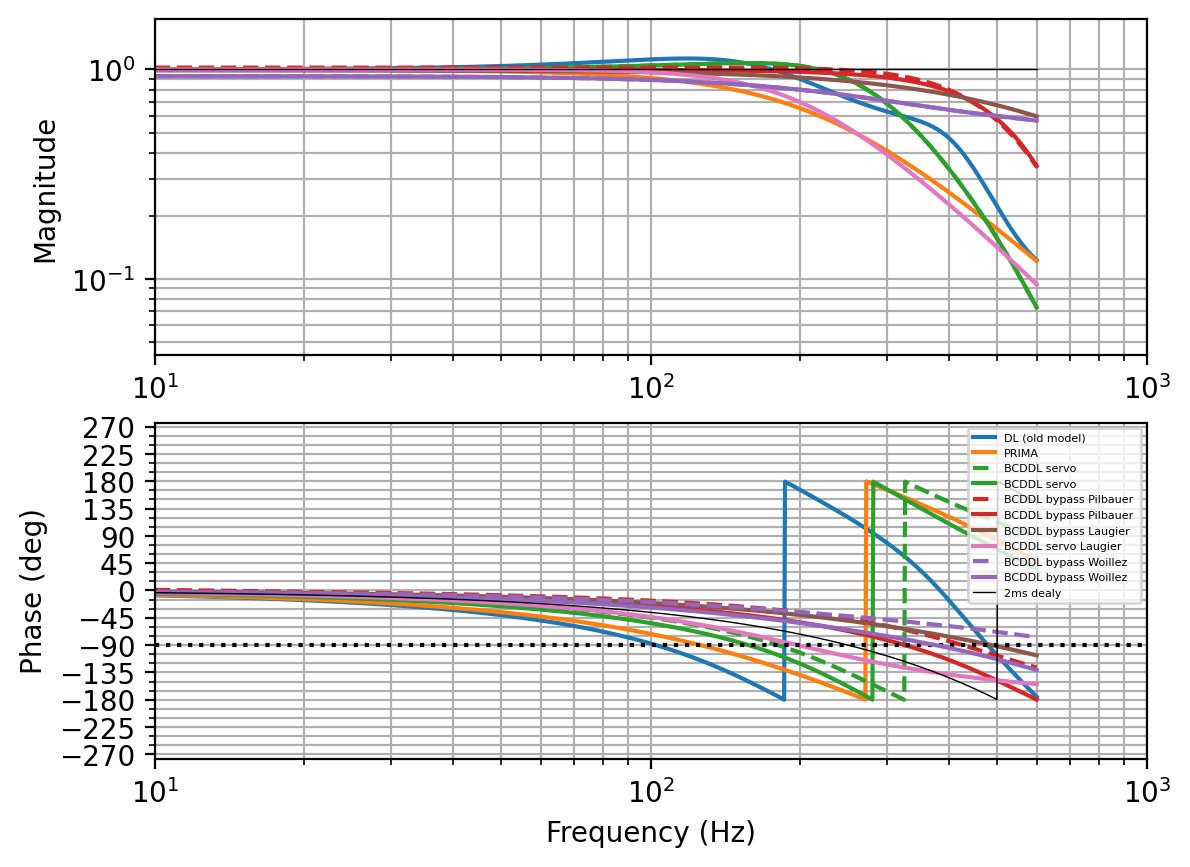

In [63]:

with open("data/fitted_BCDDL_TF.p", "rb") as afile:
    BCDDL_TF = tf_upgrade(pickle.load(afile))
with open("data/fitted_DL_TF.p", "rb") as afile:
    DL_TF = tf_upgrade(pickle.load(afile))
with open("data/fitted_DL_TF_2.p", "rb") as afile:
    DL_TF_2 = tf_upgrade(pickle.load(afile))
omega_limits = 2*np.pi*np.array([10, 600])
plt.figure(dpi=200)
dump = control.bode_plot(DL_TF, label="DL (old model)", omega_limits=omega_limits,
                         Hz=True, wrap_phase=True, color="C0", linestyle="-")
# dump = control.bode_plot(DL_TF_2, label="DL (new model)", omega_limits=omega_limits, Hz=True, wrap_phase=True)
dump = control.bode_plot(prima_design_discrete_4kHz, label="PRIMA", omega_limits=omega_limits,
                         Hz=True, wrap_phase=True, color="C1", linestyle="-")
# dump = control.bode_plot(BCDDL_TF, label="BCDDL", omega_limits=omega_limits, Hz=True, wrap_phase=True)
dump = control.bode_plot(nolag_fitted_closed_bcddl, label="BCDDL servo", omega_limits=omega_limits,
                         Hz=True, wrap_phase=True, color="C2", linestyle="--")
dump = control.bode_plot(fitted_closed_bcddl, label="BCDDL servo", omega_limits=omega_limits,
                         Hz=True, wrap_phase=True, color="C2", linestyle="-")
dump = control.bode_plot(raw_bcddl_piezo_fo13, label="BCDDL bypass Pilbauer ", omega_limits=omega_limits,
                         Hz=True, wrap_phase=True, color="C3", linestyle="--")

# dump = control.bode_plot(bcddl_piezo, label="BCDDL feedforward +250µs", omega_limits=omega_limits, Hz=True, wrap_phase=True,
#                                              linestyle="-", color="k")

dump = control.bode_plot(fitted_ffw_bcddlt_fo13, label="BCDDL bypass Pilbauer", omega_limits=omega_limits, Hz=True, wrap_phase=True,
                                             linestyle="-", color="C3")
dump = control.bode_plot(1/z_control * fitted_lowpass_bypass, label="BCDDL bypass Laugier ", omega_limits=omega_limits,
                         Hz=True, wrap_phase=True, color="C5", linestyle="-")
dump = control.bode_plot(fitted_lowpass_servo, label="BCDDL servo Laugier ", omega_limits=omega_limits,
                         Hz=True, wrap_phase=True, color="C6", linestyle="-")
plt.axhline(-90., color="k", linestyle=":")

dump = control.bode_plot(fitted_ffw_bcddl_nolag, label="BCDDL bypass Woillez", omega_limits=omega_limits,
                         Hz=True, wrap_phase=True, color="C4", linestyle="--")
dump = control.bode_plot(fitted_ffw_bcddl, label="BCDDL bypass Woillez", omega_limits=omega_limits, Hz=True, wrap_phase=True,
                                             linestyle="-", color="C4")
dump = control.bode_plot(1/z_control**4, label="2ms dealy", omega_limits=omega_limits, Hz=True, wrap_phase=True,
                                             linestyle="-", color="k", linewidth=0.5)

plt.xlim(10, 1000)
plt.legend(fontsize=4)
plt.show()

# Exporting to MATLAB

In [64]:
display(fitted_closed_bcddl)
np.savetxt("data/tfs/fitted_closed_loop_num.txt", np.squeeze(fitted_closed_bcddl.num))
np.savetxt("data/tfs/fitted_closed_loop_den.txt", np.squeeze(fitted_closed_bcddl.den))
display(fitted_ffw_bcddl)
np.savetxt("data/tfs/fitted_ffw_num.txt", np.squeeze(fitted_ffw_bcddl.num))
np.savetxt("data/tfs/fitted_ffw_den.txt", np.squeeze(fitted_ffw_bcddl.den))

TransferFunction(array([0.00214068, 0.01053243, 0.01858585, 0.00648452, 0.00801342]), array([ 1.        , -2.52256796,  2.52322637, -1.17920193,  0.22430042,
        0.        ]), 0.00025)

TransferFunction(array([ 0.15982309, -0.29070138,  0.77219682, -0.60854731,  0.52219275,
       -0.39223348,  0.10539477]), array([ 1.        , -2.41471136,  4.37352942, -4.49352123,  2.59224552,
       -0.9706425 ,  0.20140688,  0.        ]), 0.00025)

# Creating the filters


In [65]:
ts = z_control.dt
derivator_simple = 1/ts*( 1 - z_control**(-1))
integrator_simple = ts*1/(1-z_control**(-1))
s, z = sp.symbols("s, z")
T = sp.symbols("T", real=True)
re_order = 2
z_continuous = sp.series(sp.exp(s*T/2), x=s, n=re_order).removeO()/sp.series(sp.exp(-s*T/2), x=s, n=re_order).removeO()
s_approx_1 = sp.solve(z_continuous-z, s)[0]

derivator_adv_sp = s_approx_1.subs([(z, z_control),
                             (T,ts)])
derivator_adv = sp2control(derivator_adv_sp, T, dt=ts)
my_derivator = derivator_adv
integrator_adv_sp = (1/s_approx_1).subs([(z, z_control),
                             (T,ts)])
integrator_adv = sp2control(integrator_adv_sp, T, dt=ts)
double_integrator = integrator_simple*integrator_simple
double_integrator_adv = integrator_adv * integrator_adv
#integrator = control.tf(integrator, dt=ts)

In [66]:
hpfilter_5 = sig.butter(3, 2.3, btype="highpass", fs=1/z_control.dt)
highpass_5 = control.tf(*hpfilter_5, z_control.dt, )

In [67]:
import art
def checkstable(tf):
    cond = np.alltrue(np.abs(tf.poles())<=1.)
    print(np.abs(tf.poles())<=1.)
    if cond:
        print(art.art("stars"))
        art.tprint("Good", font="fp2")
    else:
        art.tprint("Bad", font="fp2")

# Closed

/tmp/ipykernel_124755/924602177.py:6: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  checkstable(inverted_bcddl_closed)


[ True  True  True  True  True  True]
✌⊂(✰‿✰)つ✌
 #####    #####    #####   ######   
 #   ##  ### ###  ### ###   ## ###  
##       ##   ##  ##   ##   ##  ##  
##  ###  ##   ##  ##   ##   ##  ##  
##   ##  ##   ##  ##   ##   ##  ##  
 #   ##  ### ###  ### ###   ## ###  
 #####    #####    #####   ######   
                                    



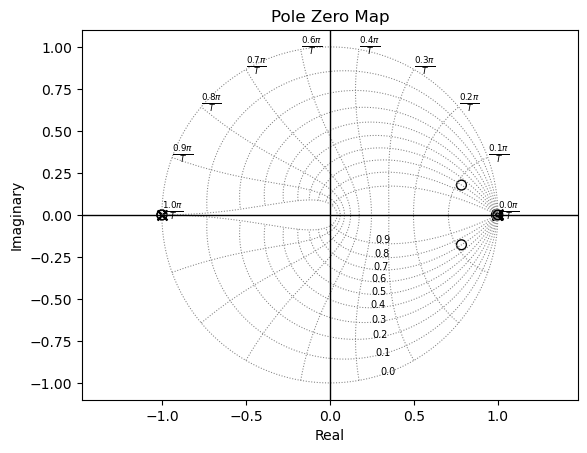

7.6534900433e-07 -1.5659617292e+00 6.4463084363e-01 -1.9893021985e+00 9.8932876547e-01
1.0000000000e+00 -1.9909773934e+00 9.9097739337e-01 -1.9960653391e+00 9.9608073005e-01
1.0000000000e+00 2.0000000000e+00 1.0000000000e+00 2.0000000000e+00 1.0000000000e+00


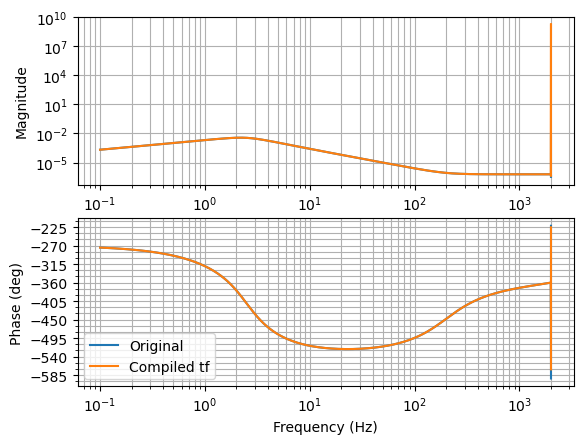

Max error on amp: 1.6894022348591664e-09
Max error on phase: 8.13121886267254e-07
All close (1e-6)
True
True
#
# Line of filter for Filter_Broad
#
TAC_BLOCK Filter_Broad_TF0 DigitalTF 7.653490043301387e-07 -1.565961729171919e+00 6.446308436321714e-01 -1.989302198451779e+00 9.893287654720109e-01 # //color=darkgreen
TAC_BLOCK Filter_Broad_TF1 DigitalTF 1.000000000000000e+00 -1.990977393368566e+00 9.909773933685659e-01 -1.996065339092038e+00 9.960807300461659e-01 # //color=darkgreen
TAC_BLOCK Filter_Broad_TF2 DigitalTF 1.000000000000000e+00 2.000000000000001e+00 1.000000000000000e+00 1.999999999999999e+00 9.999999999999987e-01 # //color=darkgreen

TAC_LINK Filter_Broad_L0    Sum_Broad 1    Filter_Broad_TF0    1  # //color=darkgreen
TAC_LINK Filter_Broad_L1    Filter_Broad_TF0 1    Filter_Broad_TF1    1  # //color=darkgreen
TAC_LINK Filter_Broad_L2    Filter_Broad_TF1 1    Filter_Broad_TF2    1  # //color=darkgreen
TAC_LINK Filter_Broad_L3    Filter_Broad_TF2 1    Opl_tot    1  # //color=d

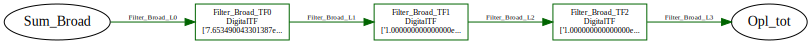

In [68]:
# inverted_bcddl_closed = hp_pll_int * pytac.get_stable_approx_inverse(fitted_lowpass_servo, 
#                                                         z=z, z_control=z_control,
#                                                         regularize=False,
#                                                         verbose=True, fmax=2000)
inverted_bcddl_closed = hp_pll_int * 1/(fitted_lowpass_servo)
checkstable(inverted_bcddl_closed)
plt.figure(dpi=100)
control.pzmap(inverted_bcddl_closed, grid=True)
plt.show()
params = pytac.tf2tac_sos(inverted_bcddl_closed, z_control, verbose=False)


pytac.save_filter("/tmp/filter_A_inverse.csv", params)
pytac.check_tac(params, inverted_bcddl_closed, zc=z_control)
names = [f"TF_BCDDL_closed_M{i}" for i in np.arange(1,4)]
input_blocks = [f"Acc_M{i}" for i in np.arange(1,4)]
output_blocks = [f"Opl_Sign_M{i}" for i in np.arange(1,4)]
names = ["Filter_Broad"]
input_blocks = ["Sum_Broad"]
output_blocks = ["Opl_tot"]
tac_plan_a = "\n".join([pytac.params2source(params, basename=aname, 
                             input_block=inblock,
                             output_block=outblock,
                 printit=False) for aname, inblock, outblock in zip(names, input_blocks, output_blocks) ])
print(tac_plan_a)
with open("src_output/BCDDL_closed_snipped.tacsrc", "w") as afile:
    afile.write(tac_plan_a)
tac_plan_a_graph = pytac.tac_obj(src=tac_plan_a.splitlines())
tac_plan_a_graph.graph

# Bypass

[ True  True  True  True  True]
✌⊂(✰‿✰)つ✌
 #####    #####    #####   ######   
 #   ##  ### ###  ### ###   ## ###  
##       ##   ##  ##   ##   ##  ##  
##  ###  ##   ##  ##   ##   ##  ##  
##   ##  ##   ##  ##   ##   ##  ##  
 #   ##  ### ###  ### ###   ## ###  
 #####    #####    #####   ######   
                                    



/tmp/ipykernel_124755/1876320343.py:6: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  checkstable(inverted_bcddl_ffw)


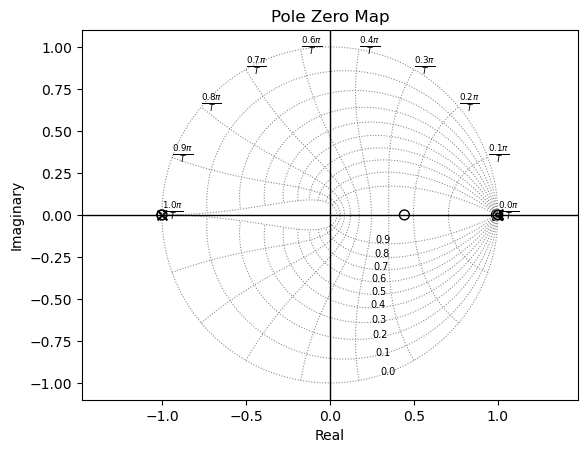

5.4641049177e-08 -4.4348155485e-01 0.0000000000e+00 -9.9322149664e-01 0.0000000000e+00
1.0000000000e+00 -1.9909773934e+00 9.9097739337e-01 -1.9960653194e+00 9.9608071038e-01
1.0000000000e+00 2.0000000000e+00 1.0000000000e+00 3.9192784711e-03 -9.9608072153e-01


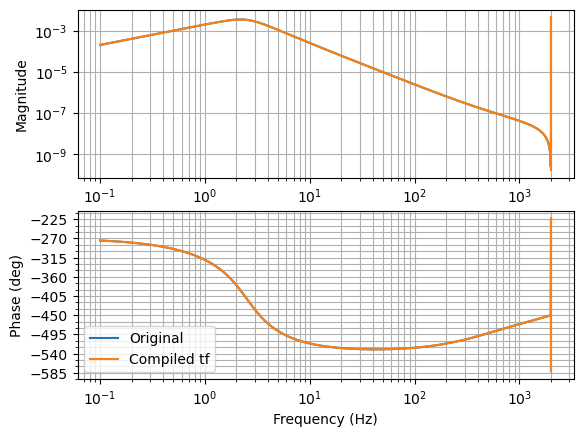

Max error on amp: 3.7863776814438255e-09
Max error on phase: 1.6908603424070634e-06
All close (1e-6)
True
True
#
# Line of filter for Filter_Broad
#
TAC_BLOCK Filter_Broad_TF0 DigitalTF 5.464104917706881e-08 -4.434815548546032e-01 0.000000000000000e+00 -9.932214966354299e-01 0.000000000000000e+00 # //color=darkgreen
TAC_BLOCK Filter_Broad_TF1 DigitalTF 1.000000000000000e+00 -1.990977393368563e+00 9.909773933685628e-01 -1.996065319379487e+00 9.960807103782232e-01 # //color=darkgreen
TAC_BLOCK Filter_Broad_TF2 DigitalTF 1.000000000000000e+00 2.000000000000001e+00 1.000000000000001e+00 3.919278471095078e-03 -9.960807215289027e-01 # //color=darkgreen

TAC_LINK Filter_Broad_L0    Sum_Broad 1    Filter_Broad_TF0    1  # //color=darkgreen
TAC_LINK Filter_Broad_L1    Filter_Broad_TF0 1    Filter_Broad_TF1    1  # //color=darkgreen
TAC_LINK Filter_Broad_L2    Filter_Broad_TF1 1    Filter_Broad_TF2    1  # //color=darkgreen
TAC_LINK Filter_Broad_L3    Filter_Broad_TF2 1    Opl_tot    1  # //colo

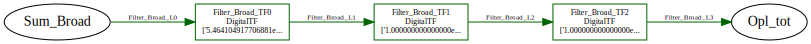

In [69]:
# inverted_bcddl_ffw = hp_pll_int * 1/(z_control**2 * fitted_ffw_bcddl)
# inverted_bcddl_ffw = hp_pll_int * pytac.get_stable_approx_inverse(fitted_ffw_bcddl, 
#                                                         z=z, z_control=z_control, verbose=True, fmax=2000,
#                                                         regularize=True)
inverted_bcddl_ffw = hp_pll_int * 1/(fitted_lowpass_bypass)
checkstable(inverted_bcddl_ffw)
plt.figure(dpi=100)
control.pzmap(inverted_bcddl_ffw, grid=True)
plt.show()
params = pytac.tf2tac_sos(inverted_bcddl_ffw, z_control, verbose=False)

pytac.save_filter("/tmp/filter_A_inverse.csv", params)
pytac.check_tac(params, inverted_bcddl_ffw, zc=z_control)
names = [f"TF_BCDDL_FFW_M{i}" for i in np.arange(1,4)]
input_blocks = [f"Acc_M{i}" for i in np.arange(1,4)]
output_blocks = [f"Opl_Sign_M{i}" for i in np.arange(1,4)]
names = ["Filter_Broad"]
input_blocks = ["Sum_Broad"]
output_blocks = ["Opl_tot"]
tac_plan_a = "\n".join([pytac.params2source(params, basename=aname, 
                             input_block=inblock,
                             output_block=outblock,
                 printit=False) for aname, inblock, outblock in zip(names, input_blocks, output_blocks) ])
print(tac_plan_a)
with open("src_output/BCDDL_FFW_snipped.tacsrc", "w") as afile:
    afile.write(tac_plan_a)
tac_plan_a_graph = pytac.tac_obj(src=tac_plan_a.splitlines())
tac_plan_a_graph.graph

hp_pll_int


TransferFunction(array([ 1.50523321e-08,  1.35811271e-10, -2.99688529e-08, -1.35811271e-10,
        1.49165208e-08]), array([ 1.        , -3.98536754,  5.95618666, -3.95627044,  0.98545132]), 0.00025)

bandfilter : 


TransferFunction(array([ 1.549274e-08+1.11848661e-09j,  0.000000e+00+0.00000000e+00j,
       -3.098548e-08-2.23697323e-09j,  0.000000e+00+0.00000000e+00j,
        1.549274e-08+1.11848661e-09j]), array([ 1.        , -3.98653875,  5.95983817, -3.9600592 ,  0.98675978]), 0.00025)

TransferFunction(array([ 0.99639368, -2.98918105,  2.98918105, -0.99639368]), array([ 1.        , -2.99277434,  2.98557476, -0.99280038]), 0.00025)

bandfilter_2 : 


TransferFunction(array([ 1.5577167e-08+1.19423567e-09j,  1.5577167e-08+1.19423567e-09j,
       -1.5577167e-08-1.19423567e-09j, -1.5577167e-08-1.19423567e-09j]), array([ 1.        , -2.98732401,  2.97472754, -0.9874033 ,  0.        ]), 0.00025)

/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/control/xferfcn.py:1113: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


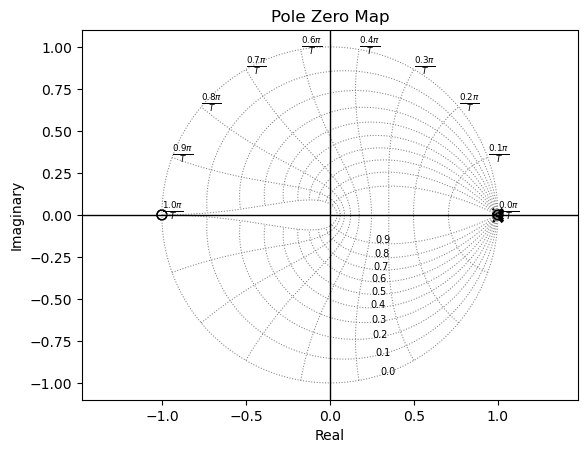

In [70]:
def rngcpx(loc=0, scale=1.,  size=(1,)):
    a = np.random.normal(loc=loc, scale=sclale, size=size)
    b = np.random.normal(loc=loc, scale=sclale, size=size)
    return a+ib

def shepperd_pole(apole):
    if sp.Abs(apole)>1.:
        newpole = apole - 2*(apole - apole/np.abs(apole))
        return newpole
    else :
        return apole


def fix_pairs(z, tol):
    zc, zr = sig._filter_design._cplxreal(z, tol)
    allzs = []
    for azc in zc:
        allzs.append(azc)
        allzs.append(np.conj(azc))
    for azr in zr:
        allzs.append(azr)
    return np.array(allzs)

def tf_fix_pair(atf, tol):
    z, p, k = sig.tf2zpk(atf.num[0][0], atf.den[0][0])
    newtf = sig.zpk2tf(fix_pairs(z, tol), fix_pairs(p, tol), k)
    return control.tf(*newtf, dt=atf.z.dt)
    
ref_omega = 100.*2*np.pi


print("hp_pll_int")
display(hp_pll_int)

ref_response = control.frequency_response(double_integrator, omega=ref_omega)
f_cut = 3.
bfilter = sig.butter(2.0, (f_cut, 3*f_cut), btype="bandpass", output="ba", fs=1/z_control.dt)
bandfilter = control.tf(*bfilter, dt=z_control.dt)
coeff = ref_response.fresp[0][0] / control.frequency_response(bandfilter, ref_response.omega).fresp[0][0]
bandfilter = bandfilter * coeff
print("bandfilter : ")
display(bandfilter)
inverted_bcddl_closed_shifted1 = bandfilter * 1/fitted_lowpass_servo

hpfilter_5 = sig.butter(3, 2.3, btype="highpass", fs=1/z_control.dt)
highpass_5 = control.tf(*hpfilter_5, z_control.dt, )
display(highpass_5)

shifted_freq = 3.0
repfs = [1.0, 1.2, 1.8]
hpfilter_6 = sig.butter(1, repfs[1]*shifted_freq, btype="lowpass", fs=1/z_control.dt)
highpass_6 = control.tf(*hpfilter_6, z_control.dt, )
bfilter_2 = sig.cheby1(1, rp=1.1, Wn=(repfs[0]*shifted_freq, repfs[2]*shifted_freq), btype="bandpass", fs=1/z_control.dt)
# hpfilter_6 = sig.butter(1, repfs[1]*shifted_freq, btype="lowpass", fs=1/z_control.dt)
# highpass_6 = control.tf(*hpfilter_6, z_control.dt, )
# bfilter_2 = sig.butter(1, (repfs[0]*shifted_freq, repfs[2]*shifted_freq), btype="bandpass", fs=1/z_control.dt)
bandfilter_2 = highpass_6 * control.tf(*bfilter_2, z_control.dt, )
coeff = ref_response.fresp[0][0] / control.frequency_response(bandfilter_2, ref_response.omega).fresp[0][0]
bandfilter_2 = 1/z_control**1 * bandfilter_2 * coeff
# bandfilter_2 = tf_fix_pair(bandfilter_2, 1e-8)
print("bandfilter_2 : ")
display(bandfilter_2)
inverted_bcddl_closed_shifted2 = bandfilter_2 * 1/fitted_lowpass_servo
# inverted_bcddl_closed_shifted2 = tf_fix_pair(inverted_bcddl_closed_shifted2, 1e-8)

plt.figure()
dump = control.pzmap(bandfilter, grid=True)
plt.show()

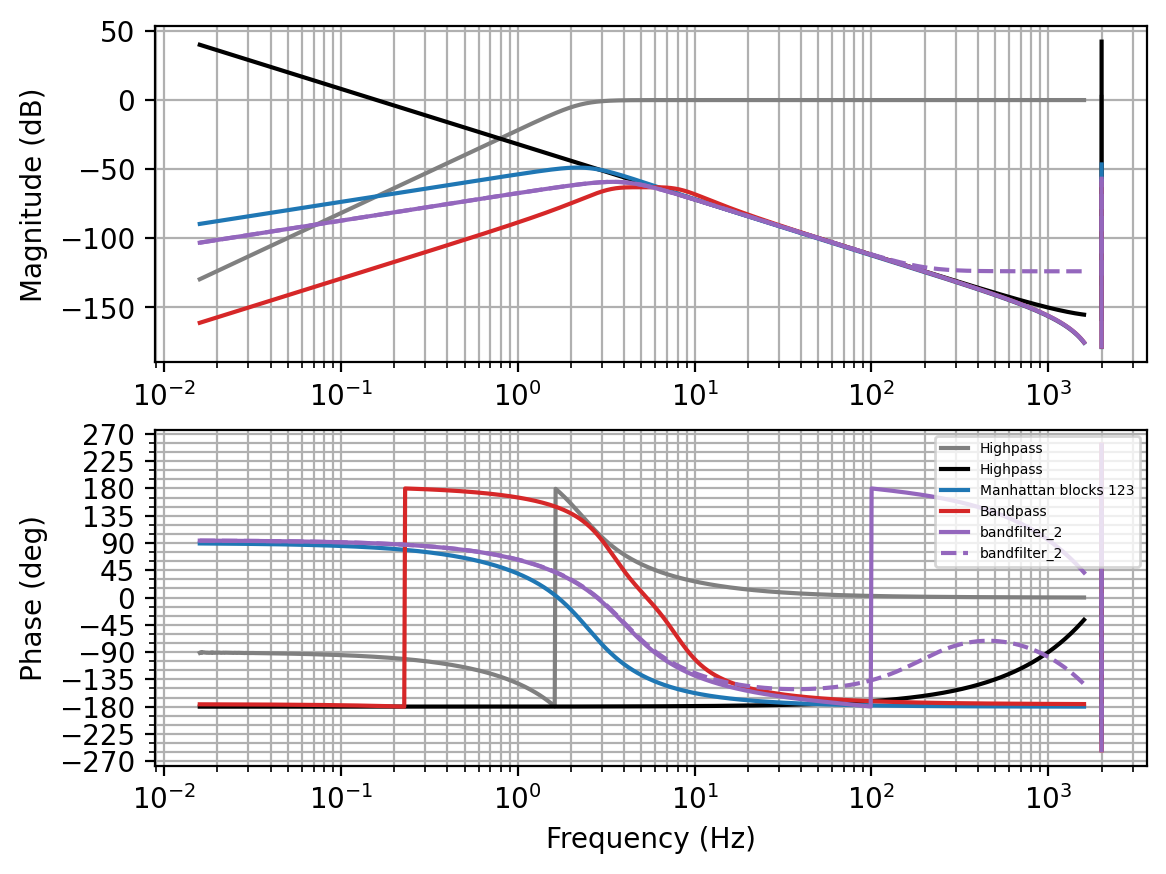

In [71]:

fig = plt.figure(dpi=200)
mag_mod, phase_mod, omega_mod = control.bode_plot(highpass_5, Hz=True, dB=True,
                                      omega_limits=(0.1, 10000), plot=True,
                                     wrap_phase=True, linestyle="-",color="gray", label="Highpass")
mag_mod, phase_mod, omega_mod = control.bode_plot(double_integrator, Hz=True, dB=True,
                                      omega_limits=(0.1, 10000), plot=True,
                                     wrap_phase=True, linestyle="-",color="k", label="Highpass")
mag_mod, phase_mod, omega_mod = control.bode_plot(hp_pll_int, Hz=True, dB=True,
                                      omega_limits=(0.1, 10000), plot=True,
                                     wrap_phase=True, linestyle="-",color="C0", label="Manhattan blocks 123")
mag_mod, phase_mod, omega_mod = control.bode_plot(bandfilter, Hz=True, dB=True,
                                      omega_limits=(0.1, 10000), plot=True,
                                     wrap_phase=True, linestyle="-",color="C3", label="Bandpass")
mag_mod, phase_mod, omega_mod = control.bode_plot(bandfilter_2, Hz=True, dB=True,
                                      omega_limits=(0.1, 10000), plot=True,
                                     wrap_phase=True, linestyle="-",color="C4", label="bandfilter_2")
mag_mod, phase_mod, omega_mod = control.bode_plot(inverted_bcddl_closed_shifted2, Hz=True, dB=True,
                                      omega_limits=(0.1, 10000), plot=True,
                                     wrap_phase=True, linestyle="--",color="C4", label="bandfilter_2")
plt.legend(fontsize=5)

/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:461: LinAlgWarning: Ill-conditioned matrix (rcond=1.04913e-85): result may not be accurate.
  ad = linalg.solve(ima, np.eye(a.shape[0]) + (1.0-alpha)*dt*a)
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:462: LinAlgWarning: Ill-conditioned matrix (rcond=1.04913e-85): result may not be accurate.
  bd = linalg.solve(ima, dt*b)
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.02124e-85): result may not be accurate.
  cd = linalg.solve(ima.transpose(), c.transpose())


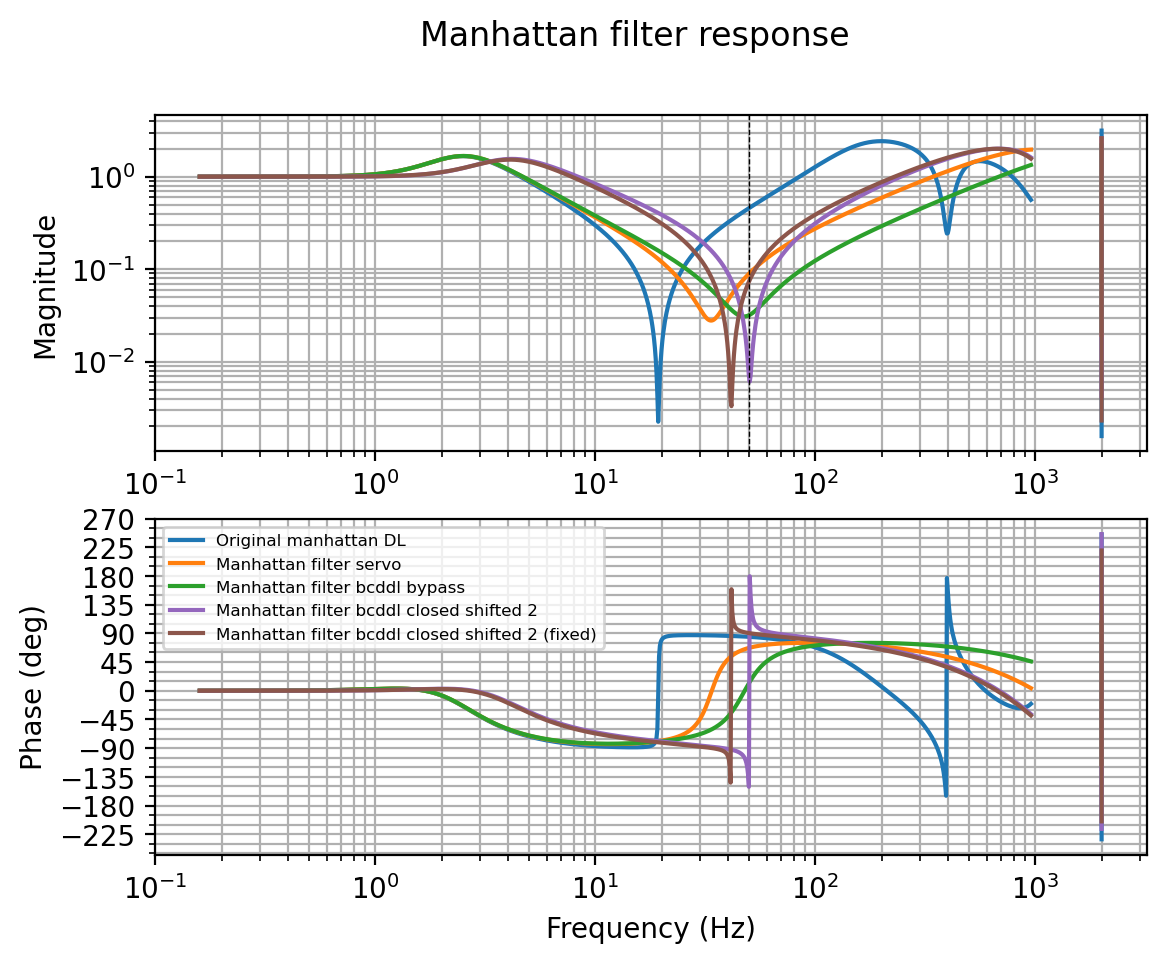

In [72]:
o13_TF = raw_bcddl_piezo_fo13.sample(Ts=z_control.dt, method="bilinear")
# o13_TF = fitted_ffw_bcddl # .sample(Ts=z_control.dt, method="bilinear")
fmax = 6000
fig = plt.figure(dpi=200)
mag_mn5_real, dump, omega_real = control.bode(
    1 - 1/z_control * tf_1 * tf_2 * tf_3 * tf_4 * DL_TF * my_derivator**2,
            wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
            label="Original manhattan DL", color="C0")
mag_mn5_real, dump, omega_real = control.bode(
    1 - inverted_bcddl_closed * fitted_lowpass_servo * fitted_lowpass_servo_delay * my_derivator**2,
            wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
            label="Manhattan filter servo", color="C1")
mag_mn5_real, dump, omega_real = control.bode(
    1 - inverted_bcddl_ffw * fitted_lowpass_bypass * fitted_lowpass_bypass_delay * my_derivator**2,
            wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
            label="Manhattan filter bcddl bypass", color="C2")
# mag_mn5_real, dump, omega_real = control.bode(
#     1 - inverted_bcddl_closed_shifted1 * fitted_closed_bcddl * my_derivator**2,
#             wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
#             label="Manhattan filter bcddl closed shifted 1", color="C3")
mag_mn5_real, dump, omega_real = control.bode(
    1 - inverted_bcddl_closed_shifted2 * fitted_lowpass_servo * fitted_lowpass_servo_delay * my_derivator**2,
            wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
            label="Manhattan filter bcddl closed shifted 2", color="C4")

mag_mn5_real, dump, omega_real = control.bode(
    1 - tf_fix_pair(inverted_bcddl_closed_shifted2, 1e-5) * fitted_lowpass_servo * fitted_lowpass_servo_delay * my_derivator**2,
            wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
            label="Manhattan filter bcddl closed shifted 2 (fixed)", color="C5")
plt.suptitle("Manhattan filter response")
plt.legend(fontsize=6)
plt.sca(fig.axes[0])
plt.axvline(50., linewidth = 0.5, color="k", linestyle="--")
plt.savefig("data/bcddl/compare_feedforward_response_new.pdf")
plt.show()


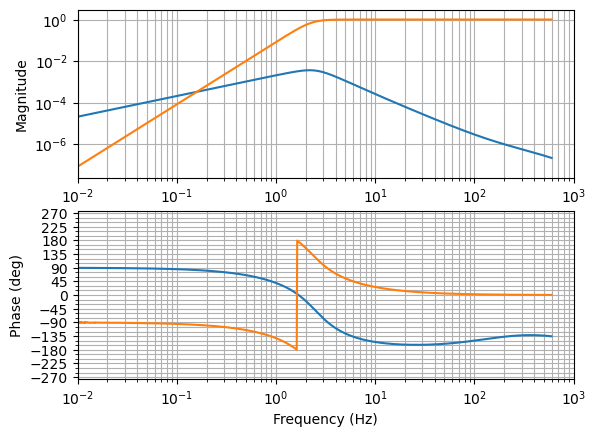

In [73]:
omega_limits = 2*np.pi*np.array([0.01, 600])
plt.figure()
dump = control.bode_plot(tf_rebuilt, label="initial_manhattan", omega_limits=omega_limits, Hz=True, wrap_phase=True)
dump = control.bode_plot(highpass_5, label="highpass_5", omega_limits=omega_limits, Hz=True, wrap_phase=True)
#dump = control.bode_plot(tf_from_manual, label="BCDDL", omega_limits=omega_limits, Hz=True, wrap_phase=True)
plt.xlim(1e-2, 1e3)
plt.show()

# Exporting for comparison

In [74]:
orig_man_rejection = 1 - 1/z_control * tf_1 * tf_2 * tf_3 * tf_4 * DL_TF * my_derivator**2
bcddl_closed_rejection = 1 - inverted_bcddl_closed * fitted_closed_bcddl * my_derivator**2
bcddl_ffw_rejection = 1 - inverted_bcddl_ffw * fitted_ffw_bcddl * my_derivator**2

In [75]:
import pickle
with open("data/rejection_orig.p", "wb") as afile:
    pickle.dump(orig_man_rejection, afile)
with open("data/rejection_bcddl_closed.p", "wb") as afile:
    pickle.dump(bcddl_closed_rejection, afile)
with open("data/rejection_bcddl_ffw.p", "wb") as afile:
    pickle.dump(bcddl_ffw_rejection, afile)
with open("data/inverted_bcddl_closed.p", "wb") as afile:
    pickle.dump(inverted_bcddl_closed, afile)


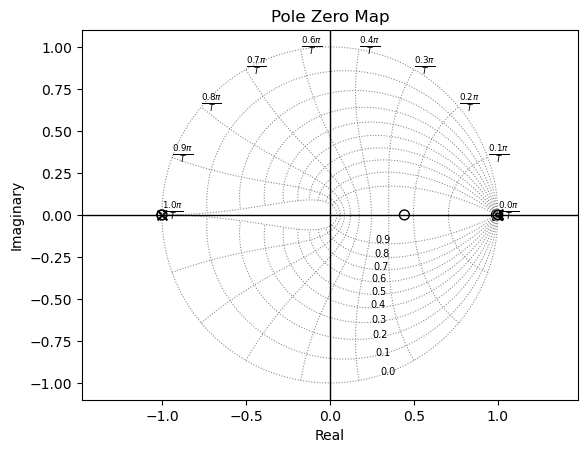

In [76]:
dump = control.pzmap(inverted_bcddl_ffw, grid=True)

In [77]:
# mirror_rejected_bcddl_ffw

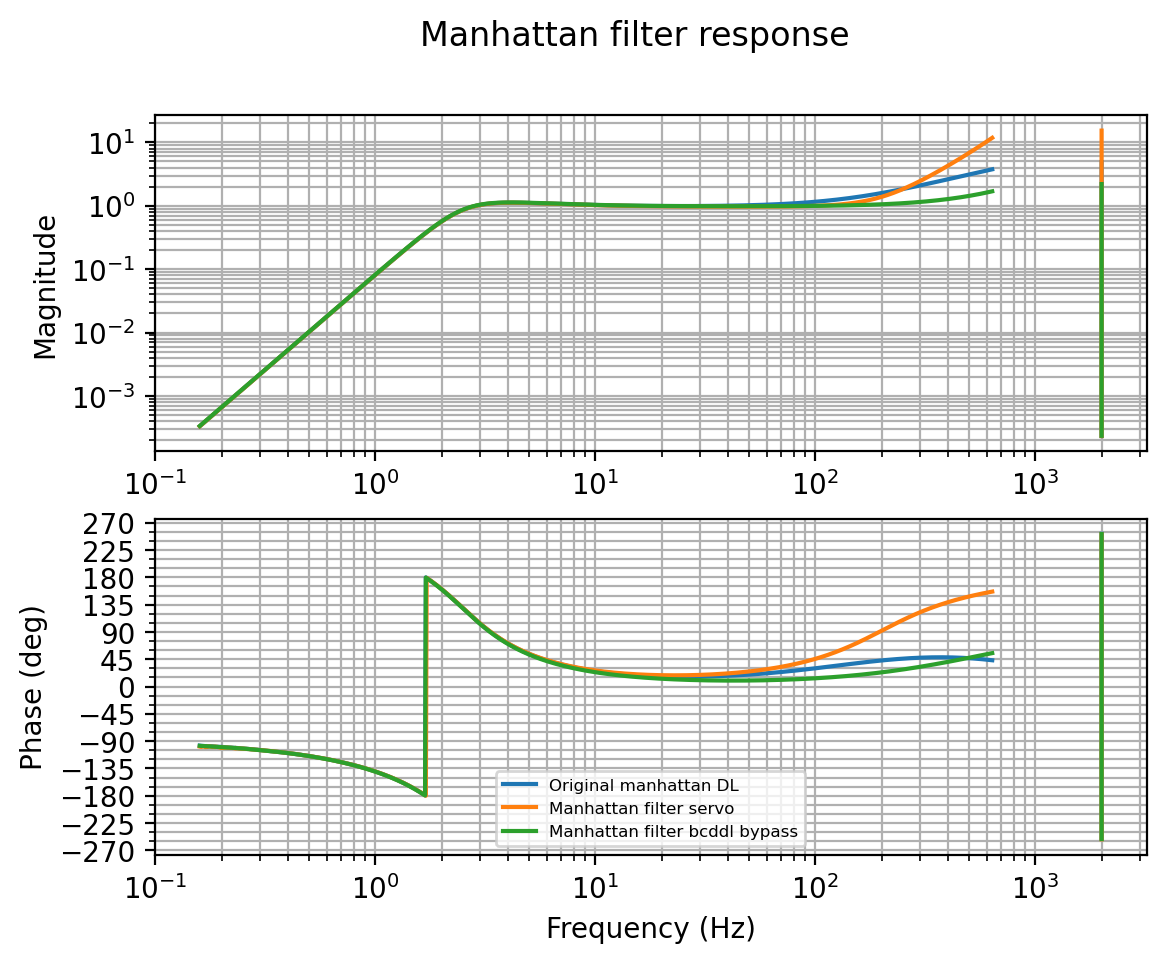

In [78]:
fmax = 4000
plt.figure(dpi=200)
mag_mn5_real, dump, omega_real = control.bode(
    tf_1 * tf_2 * tf_3 * tf_4 * my_derivator**2,
            wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
            label="Original manhattan DL", color="C0")
mag_mn5_real, dump, omega_real = control.bode(
    inverted_bcddl_closed * my_derivator**2,
            wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
            label="Manhattan filter servo", color="C1")
mag_mn5_real, dump, omega_real = control.bode(
    inverted_bcddl_ffw * my_derivator**2 ,
            wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
            label="Manhattan filter bcddl bypass", color="C2")
plt.suptitle("Manhattan filter response")
plt.legend(fontsize=6)
# plt.savefig("data/bcddl/compare_feedforward_response.pdf")
plt.show()

# Closed shifted

/tmp/ipykernel_124755/3289953494.py:5: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  checkstable(inverted_bcddl_closed_shifted2)


[ True  True  True  True  True  True]
✌⊂(✰‿✰)つ✌
 #####    #####    #####   ######   
 #   ##  ### ###  ### ###   ## ###  
##       ##   ##  ##   ##   ##  ##  
##  ###  ##   ##  ##   ##   ##  ##  
##   ##  ##   ##  ##   ##   ##  ##  
 #   ##  ### ###  ### ###   ## ###  
 #####    #####    #####   ######   
                                    



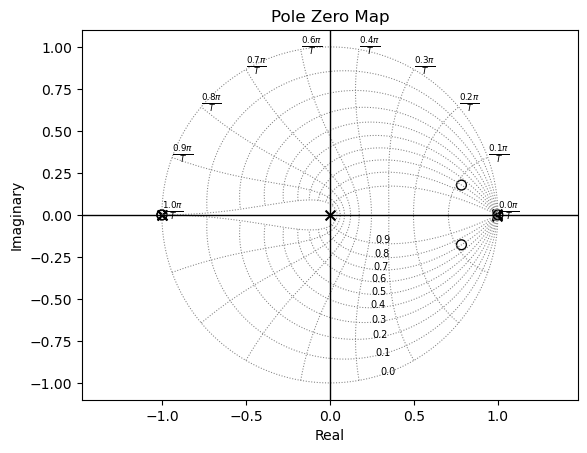

TransferFunction(array([ 7.92034693e-07, -1.24029602e-06,  5.10569992e-07]), array([ 1.        , -0.99436106,  0.        ]), 0.00025)

7.9203469263e-07 -1.5659617292e+00 6.4463084363e-01 -9.9436106192e-01 0.0000000000e+00
tfs


(7.92034692626682e-7*z**2 - 1.24029601682983e-6*z + 5.10569992093888e-7)/(z**2 - 0.99436106192125*z)

TransferFunction(array([ 1., -1.,  0.]), array([ 1.        , -1.99296295,  0.99300278]), 0.00025)

1.0000000000e+00 -1.0000000000e+00 0.0000000000e+00 -1.9929629530e+00 9.9300278493e-01
tfs


(1.0*z**2 - 0.999999999999997*z)/(z**2 - 1.99296295296237*z + 0.993002784928714)

TransferFunction(array([1., 2., 1.]), array([1., 2., 1.]), 0.00025)

1.0000000000e+00 2.0000000000e+00 1.0000000000e+00 2.0000000000e+00 1.0000000000e+00
tfs


(1.0*z**2 + 2.0*z + 1.0)/(z**2 + 2.0*z + 1.0)

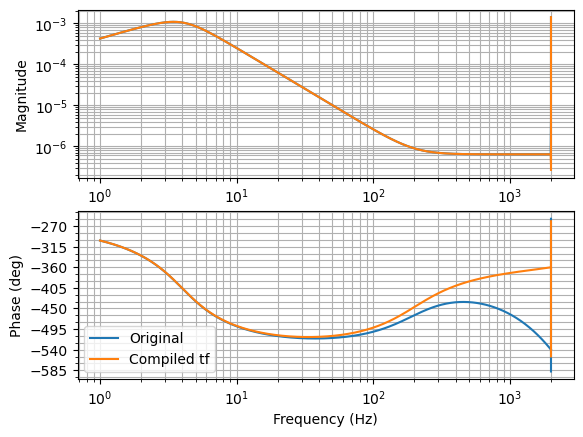

Max error on amp: 4.4058571894989296e-13
Max error on phase: 3.1003817537112255
All close (1e-6)
True
False
#
# Line of filter for Filter_Broad
#
TAC_BLOCK Filter_Broad_TF0 DigitalTF 7.920346926266821e-07 -1.565961729171922e+00 6.446308436321744e-01 -9.943610619212498e-01 0.000000000000000e+00 # //color=darkgreen
TAC_BLOCK Filter_Broad_TF1 DigitalTF 1.000000000000000e+00 -9.999999999999968e-01 0.000000000000000e+00 -1.992962952962374e+00 9.930027849287144e-01 # //color=darkgreen
TAC_BLOCK Filter_Broad_TF2 DigitalTF 1.000000000000000e+00 2.000000000000003e+00 1.000000000000003e+00 2.000000000000000e+00 9.999999999999998e-01 # //color=darkgreen

TAC_LINK Filter_Broad_L0    Sum_Broad 1    Filter_Broad_TF0    1  # //color=darkgreen
TAC_LINK Filter_Broad_L1    Filter_Broad_TF0 1    Filter_Broad_TF1    1  # //color=darkgreen
TAC_LINK Filter_Broad_L2    Filter_Broad_TF1 1    Filter_Broad_TF2    1  # //color=darkgreen
TAC_LINK Filter_Broad_L3    Filter_Broad_TF2 1    Opl_tot    1  # //color=da

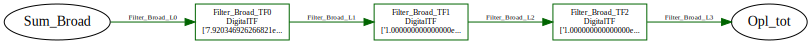

In [79]:
# inverted_bcddl_ffw = hp_pll_int * 1/(z_control**2 * fitted_ffw_bcddl)
inverted_bcddl_closed_shifted2 =  1/z_control**0 * bandfilter_2 * 1/fitted_lowpass_servo
inverted_bcddl_closed_shifted2  = tf_fix_pair(inverted_bcddl_closed_shifted2, 1e-5)

checkstable(inverted_bcddl_closed_shifted2)
plt.figure(dpi=100)
control.pzmap(inverted_bcddl_closed_shifted2, grid=True)
plt.show()
params = pytac.tf2tac_sos(inverted_bcddl_closed_shifted2, z_control, verbose=True)

pytac.save_filter("/tmp/filter_closed_shifted2_inverse.csv", params)
pytac.check_tac(params, inverted_bcddl_closed_shifted2, zc=z_control)
names = [f"TF_BCDDL_closed_shifted2_M{i}" for i in np.arange(1,4)]
input_blocks = [f"Acc_M{i}" for i in np.arange(1,4)]
output_blocks = [f"Opl_Sign_M{i}" for i in np.arange(1,4)]
names = ["Filter_Broad"]
input_blocks = ["Sum_Broad"]
output_blocks = ["Opl_tot"]
tac_plan_a = "\n".join([pytac.params2source(params, basename=aname, 
                             input_block=inblock,
                             output_block=outblock,
                 printit=False) for aname, inblock, outblock in zip(names, input_blocks, output_blocks) ])
print(tac_plan_a)
with open("src_output/BCDDL_closed_shifted2_snipped.tacsrc", "w") as afile:
    afile.write(tac_plan_a)
tac_plan_a_graph = pytac.tac_obj(src=tac_plan_a.splitlines())
tac_plan_a_graph.graph

# Bypass shifted

[ True  True  True  True  True]
✌⊂(✰‿✰)つ✌
 #####    #####    #####   ######   
 #   ##  ### ###  ### ###   ## ###  
##       ##   ##  ##   ##   ##  ##  
##  ###  ##   ##  ##   ##   ##  ##  
##   ##  ##   ##  ##   ##   ##  ##  
 #   ##  ### ###  ### ###   ## ###  
 #####    #####    #####   ######   
                                    



/tmp/ipykernel_124755/784317738.py:5: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  checkstable(inverted_bcddl_bypass_shifted)


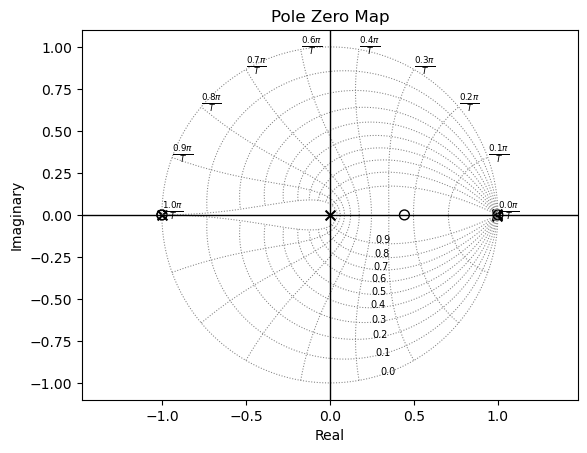

TransferFunction(array([5.65462375e-08, 0.00000000e+00, 0.00000000e+00]), array([1., 0., 0.]), 0.00025)

5.6546237527e-08 0.0000000000e+00 0.0000000000e+00 0.0000000000e+00 0.0000000000e+00
tfs


5.65462375268094e-8

TransferFunction(array([ 1.        , -1.44348155,  0.44348155]), array([ 1.        , -1.99296295,  0.99300278]), 0.00025)

1.0000000000e+00 -1.4434815549e+00 4.4348155485e-01 -1.9929629530e+00 9.9300278495e-01
tfs


(1.0*z**2 - 1.4434815548546*z + 0.443481554854602)/(z**2 - 1.99296295298727*z + 0.993002784953581)

TransferFunction(array([1., 2., 1.]), array([ 1.        ,  0.00563894, -0.99436106]), 0.00025)

1.0000000000e+00 2.0000000000e+00 1.0000000000e+00 5.6389381037e-03 -9.9436106190e-01
tfs


(1.0*z**2 + 2.0*z + 0.999999999999999)/(z**2 + 0.00563893810365212*z - 0.994361061896342)

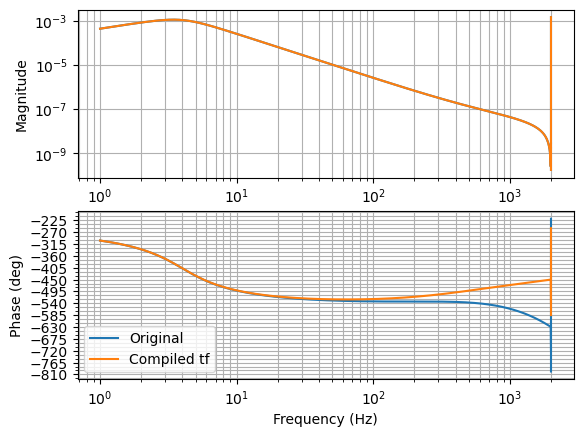

Max error on amp: 2.31268563327669e-13
Max error on phase: 3.100381753711244
All close (1e-6)
True
False
#
# Line of filter for Filter_Broad
#
TAC_BLOCK Filter_Broad_TF0 DigitalTF 5.654623752680942e-08 0.000000000000000e+00 0.000000000000000e+00 0.000000000000000e+00 0.000000000000000e+00 # //color=darkgreen
TAC_BLOCK Filter_Broad_TF1 DigitalTF 1.000000000000000e+00 -1.443481554854601e+00 4.434815548546022e-01 -1.992962952987274e+00 9.930027849535813e-01 # //color=darkgreen
TAC_BLOCK Filter_Broad_TF2 DigitalTF 1.000000000000000e+00 2.000000000000000e+00 9.999999999999993e-01 5.638938103652125e-03 -9.943610618963423e-01 # //color=darkgreen

TAC_LINK Filter_Broad_L0    Sum_Broad 1    Filter_Broad_TF0    1  # //color=darkgreen
TAC_LINK Filter_Broad_L1    Filter_Broad_TF0 1    Filter_Broad_TF1    1  # //color=darkgreen
TAC_LINK Filter_Broad_L2    Filter_Broad_TF1 1    Filter_Broad_TF2    1  # //color=darkgreen
TAC_LINK Filter_Broad_L3    Filter_Broad_TF2 1    Opl_tot    1  # //color=darkgr

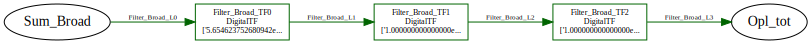

In [80]:
# inverted_bcddl_ffw = hp_pll_int * 1/(z_control**2 * fitted_ffw_bcddl)
inverted_bcddl_bypass_shifted =  1/z_control**0 * bandfilter_2 * 1/fitted_lowpass_bypass
inverted_bcddl_bypass_shifted  = tf_fix_pair(inverted_bcddl_bypass_shifted, 1e-5)

checkstable(inverted_bcddl_bypass_shifted)
plt.figure(dpi=100)
control.pzmap(inverted_bcddl_bypass_shifted, grid=True)
plt.show()
params = pytac.tf2tac_sos(inverted_bcddl_bypass_shifted, z_control, verbose=True)

pytac.save_filter("/tmp/filter_bypass_shifted_inverse.csv", params)
pytac.check_tac(params, inverted_bcddl_bypass_shifted, zc=z_control)
names = [f"TF_BCDDL_closed_shifted2_M{i}" for i in np.arange(1,4)]
input_blocks = [f"Acc_M{i}" for i in np.arange(1,4)]
output_blocks = [f"Opl_Sign_M{i}" for i in np.arange(1,4)]
names = ["Filter_Broad"]
input_blocks = ["Sum_Broad"]
output_blocks = ["Opl_tot"]
tac_plan_a = "\n".join([pytac.params2source(params, basename=aname, 
                             input_block=inblock,
                             output_block=outblock,
                 printit=False) for aname, inblock, outblock in zip(names, input_blocks, output_blocks) ])
print(tac_plan_a)
with open("src_output/BCDDL_bypass_shifted_snipped.tacsrc", "w") as afile:
    afile.write(tac_plan_a)
tac_plan_a_graph = pytac.tac_obj(src=tac_plan_a.splitlines())
tac_plan_a_graph.graph

/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:461: LinAlgWarning: Ill-conditioned matrix (rcond=1.04913e-85): result may not be accurate.
  ad = linalg.solve(ima, np.eye(a.shape[0]) + (1.0-alpha)*dt*a)
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:462: LinAlgWarning: Ill-conditioned matrix (rcond=1.04913e-85): result may not be accurate.
  bd = linalg.solve(ima, dt*b)
/lhome/romain/miniconda3/envs/control2/lib/python3.9/site-packages/scipy/signal/_lti_conversion.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.02124e-85): result may not be accurate.
  cd = linalg.solve(ima.transpose(), c.transpose())


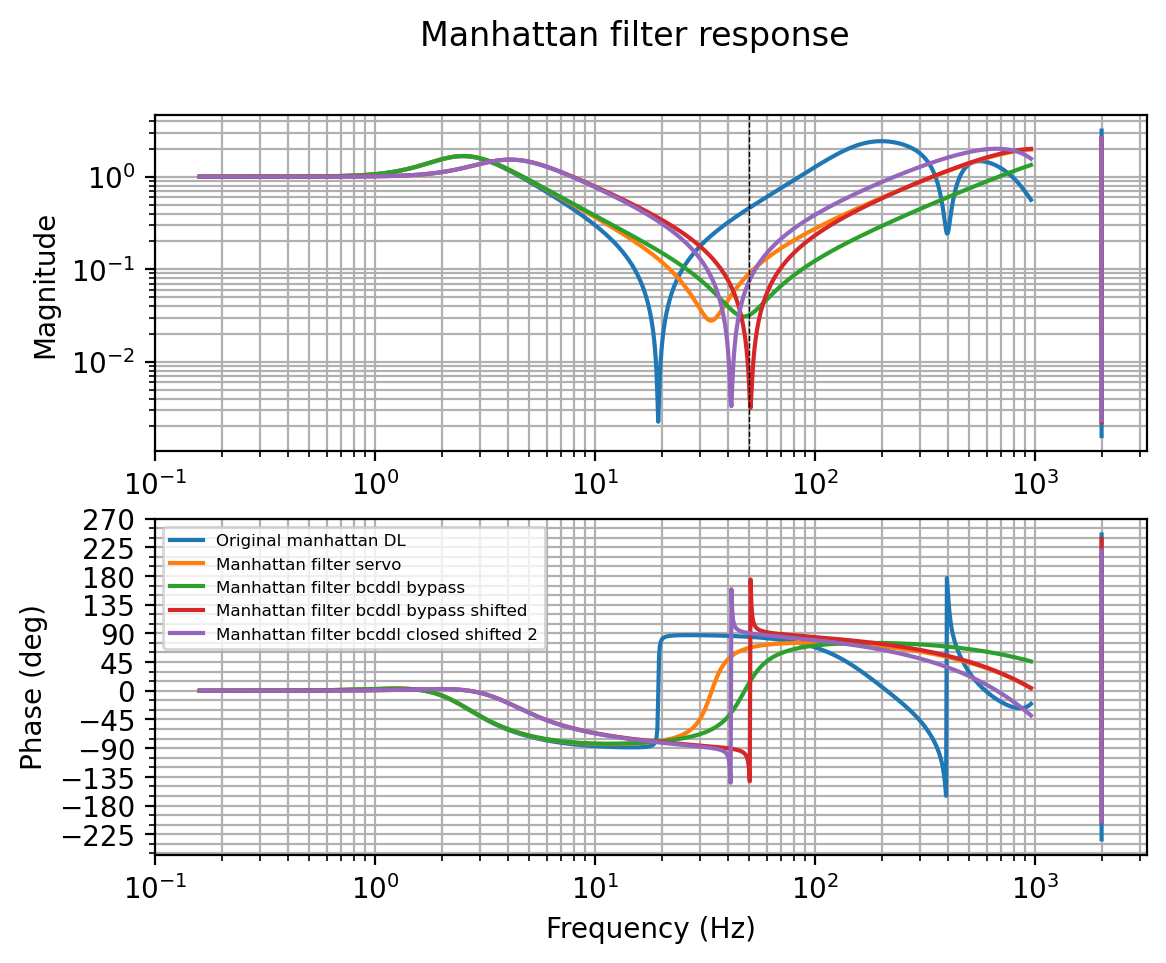

In [81]:
o13_TF = raw_bcddl_piezo_fo13.sample(Ts=z_control.dt, method="bilinear")
# o13_TF = fitted_ffw_bcddl # .sample(Ts=z_control.dt, method="bilinear")
fmax = 6000
fig = plt.figure(dpi=200)
mag_mn5_real, dump, omega_real = control.bode(
    1 - 1/z_control * tf_1 * tf_2 * tf_3 * tf_4 * DL_TF * my_derivator**2,
            wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
            label="Original manhattan DL", color="C0")
mag_mn5_real, dump, omega_real = control.bode(
    1 - inverted_bcddl_closed * fitted_lowpass_servo * fitted_lowpass_servo_delay * my_derivator**2,
            wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
            label="Manhattan filter servo", color="C1")
mag_mn5_real, dump, omega_real = control.bode(
    1 - inverted_bcddl_ffw * fitted_lowpass_bypass * fitted_lowpass_bypass_delay * my_derivator**2,
            wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
            label="Manhattan filter bcddl bypass", color="C2")
mag_mn5_real, dump, omega_real = control.bode(
    1 - inverted_bcddl_bypass_shifted * fitted_lowpass_bypass * fitted_lowpass_bypass_delay * my_derivator**2,
            wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
            label="Manhattan filter bcddl bypass shifted", color="C3")
# mag_mn5_real, dump, omega_real = control.bode(
#     1 - inverted_bcddl_closed_shifted1 * fitted_closed_bcddl * my_derivator**2,
#             wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
#             label="Manhattan filter bcddl closed shifted 1", color="C3")
mag_mn5_real, dump, omega_real = control.bode(
    1 - inverted_bcddl_closed_shifted2 * fitted_lowpass_servo * fitted_lowpass_servo_delay * my_derivator**2,
            wrap_phase=True, Hz=True,  omega_limits=(10e-1, fmax),
            label="Manhattan filter bcddl closed shifted 2", color="C4")

plt.suptitle("Manhattan filter response")
plt.legend(fontsize=6)
plt.sca(fig.axes[0])
plt.axvline(50., linewidth = 0.5, color="k", linestyle="--")
plt.savefig("data/bcddl/compare_feedforward_response_new.pdf")
plt.show()


# PLL correction

In [84]:
print(pytac.get_pl_coeffs_tf(DL_TF, 150))
print(pytac.get_pl_coeffs_tf(fitted_lowpass_bypass, 150))

{'amp': array([-0.91975368]), 'neg_1/amp': array([-0.91975368]), 'phi': array([-2.47094409]), 'tau_pd': 0.13333333333333333, 'ua': array([-0.78341875]), 'ub': array([-0.62149422]), 'ug': array([-0.91975368])}
{'amp': array([-1.05662782]), 'neg_1/amp': array([-1.05662782]), 'phi': array([-0.29786003]), 'tau_pd': 0.13333333333333333, 'ua': array([0.9559667]), 'ub': array([-0.29347514]), 'ug': array([-1.05662782])}


In [83]:
def fix_pairs(z, tol):
    zc, zr = sig._filter_design._cplxreal(z, tol)
    allzs = []
    for azc in zc:
        allzs.append(azc)
        allzs.append(np.conj(azc))
    for azr in zr:
        allzs.append(azr)
    return np.array(allzs)

def tf_fix_pair(atf, tol):
    z, p, k = sig.tf2zpk(atf.num[0][0], atf.den[0][0])
    newtf = sig.zpk2tf(fix_pairs(z, tol), fix_pairs(p, tol), k)
    return control.tf(*newtf, dt=atf.z.dt)

In [163]:
az = sig.tf2zpk(bandfilter_2.num[0][0], bandfilter_2.den[0][0])
print(az[0])
print(fix_pairs(az[0], tol=1e-8))

[ 1.+9.54615892e-18j -1.-2.30962098e-08j -1.+2.30962100e-08j]
[-1.+2.30962099e-08j -1.-2.30962099e-08j  1.+0.00000000e+00j]
